In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from google.colab import drive

from keras.utils import np_utils

from tensorflow.keras.backend import clear_session
from tensorflow import Tensor
from tensorflow.keras import regularizers, utils
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import he_normal, random_normal
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


# Import dataset

In [ ]:
drive.mount('/content/drive')
raw_data_pd = pd.read_pickle(r'drive/MyDrive/AML_2022-2023/data_raw.pkl')

Mounted at /content/drive


In [ ]:
a = raw_data_pd['user'].value_counts()
print(a)

COV+_476H    25
COV-_482H    25
CTRL_18      25
CTRL_27      25
CTRL_10      25
             ..
CTRL_36      25
CTRL_11      20
CTRL_08      20
CTRL_06      20
CTRL_01      16
Name: user, Length: 101, dtype: int64


In [ ]:
a.values

array([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 20, 20, 20, 16])

In [ ]:
raw_data_pd

user name   raw                                            spectra  \
0     COV+_476H  Raw  True  [12399.0, 12193.0, 12193.0, 12129.0, 12271.0, ...   
1     COV+_476H  Raw  True  [15159.0, 15495.0, 15427.0, 15049.0, 15309.0, ...   
2     COV+_476H  Raw  True  [18837.0, 19091.0, 18953.0, 18957.0, 18969.0, ...   
3     COV+_476H  Raw  True  [15157.0, 15089.0, 14927.0, 15153.0, 15049.0, ...   
4     COV+_476H  Raw  True  [17851.0, 18043.0, 17943.0, 18015.0, 18117.0, ...   
...         ...  ...   ...                                                ...   
2496    CTRL_36  Raw  True  [14975.0, 14767.0, 14873.0, 14741.0, 14853.0, ...   
2497    CTRL_36  Raw  True  [14609.0, 14579.0, 14609.0, 14567.0, 14503.0, ...   
2498    CTRL_36  Raw  True  [11993.0, 11949.0, 11911.0, 11765.0, 11851.0, ...   
2499    CTRL_36  Raw  True  [11137.0, 11111.0, 10947.0, 11045.0, 11017.0, ...   
2500    CTRL_36  Raw  True  [13715.0, 13753.0, 13651.0, 13875.0, 13845.0, ...   

     category                                             x-axis  
0        COV+  [401.286, 402.641, 403.996, 405.35, 406.705, 4...  
1        COV+  [401.286, 402.641, 403.996, 405.35, 406.705, 4...  
2        COV+  [401.286, 402.641, 403.996, 405.35, 406.705, 4...  
3        COV+  [401.286, 402.641, 403.996, 405.35, 406.705, 4...  
4        COV+  [401.286, 402.641, 403.996, 405.35, 406.705, 4...  
...       ...                                                ...  
2496     CTRL  [401.279, 402.634, 403.989, 405.344, 406.697, ...  
2497     CTRL  [401.279, 402.634, 403.989, 405.344, 406.697, ...  
2498     CTRL  [401.279, 402.634, 403.989, 405.344, 406.697, ...  
2499     CTRL  [401.279, 402.634, 403.989, 405.344, 406.697, ...  
2500     CTRL  [401.279, 402.634, 403.989, 405.344, 406.697, ...  

[2501 rows x 6 columns]

In [ ]:
np.shape(raw_data_pd)

(2501, 6)

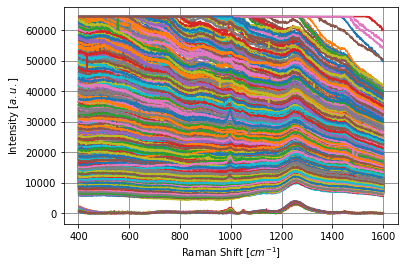

In [ ]:
for i in range(2500):
    plt.plot(raw_data_pd['x-axis'][i], raw_data_pd['spectra'][i])

plt.grid(color='grey')
plt.xlabel('Raman Shift [$cm^{-1}$]')
plt.ylabel('Intensity [$a.u.$]')

plt.savefig('complete_dataset.png', dpi=300)
plt.show()

# Helper functions

In [ ]:
def draw_by_index(data_obj, idx, draw_legend=True):
  plt.plot(data_obj['x-axis'][idx], data_obj['spectra'][idx], label=f'{data_obj["user"][idx]} ({idx})')
  if draw_legend:
    plt.legend()

def draw_by_user(data_obj, user):
  for i, x in enumerate(data_obj['user']):
    if x == user:
      plt.plot(data_obj['x-axis'][i], data_obj['spectra'][i])

def draw_by_category(data_obj, category):
  for i, x in enumerate(data_obj['category']):
    if x == category:
      plt.plot(data_obj['x-axis'][i], data_obj['spectra'][i])

def is_outlier(data_obj, idx, treshold=1200, val_out=64500):
  spectra = data_obj['spectra'][idx]
  x = data_obj['x-axis'][idx]
  ma_arr = np.ma.masked_less(x, treshold)
  masked = np.ma.masked_where(np.ma.getmask(ma_arr), spectra)
  return masked.max() == val_out

def how_many_outliers(data_obj, treshold=1200, val_out=64500):
  count = 0
  for idx, _ in enumerate(data_obj['user']):
    if is_outlier(data_obj, idx, treshold, val_out):
      count += 1
  return count

def get_dataset_no_outliers(data_obj, treshold=1200, val_out=64500):
  new_df = data_obj.copy()
  idexes_outliers = []
  for idx, _ in enumerate(data_obj['user']):
    if is_outlier(data_obj, idx, treshold, val_out):
      idexes_outliers.append(idx)
  return new_df.drop(idexes_outliers).reset_index()

def get_dataset_fitted(data_obj, deg=4, val_out=64500):
  new_df = data_obj.copy()
  for idx, _ in enumerate(new_df['user']):
    y = get_fitted(new_df, idx, deg, val_out)
    #new_df.loc[idx, 'spectra'] = new_df['spectra'][idx] - y
    new_df['spectra'][idx] = new_df['spectra'][idx] - y
  return new_df

def get_fitted(data_obj, idx, deg=5, val_out=64500):
  y = data_obj['spectra'][idx]
  my = np.ma.masked_equal(y, val_out)
  x = data_obj['x-axis'][idx]
  mx = np.ma.masked_where(np.ma.getmask(my), x)
  poly = np.polyfit(mx, my, deg=deg)
  return np.polyval(poly, mx).filled(val_out)

def draw_by_index_fitted(data_obj, idx, deg=5, draw_legend=True):
  x = data_obj['x-axis'][idx]
  y = data_obj['spectra'][idx]
  fit = get_fitted(data_obj, idx, deg)
  plt.plot(x, y-fit, label=f'{data_obj["user"][idx]} ({idx})')
  if draw_legend:
    plt.legend()

def draw_by_user_fitted(data_obj, user, deg=5):
  for i, x in enumerate(data_obj['user']):
    if x == user:
      draw_by_index_fitted(data_obj, i, deg, False)

def draw_by_category_fitted(data_obj, category, deg=5):
  for i, x in enumerate(data_obj['category']):
    if x == category:
      draw_by_index_fitted(data_obj, i, deg, False)

In [ ]:
def plot_history(history, validation=True):
  
  fig, axs = plt.subplots(1, 2, figsize=(20,5))

  axs[0].plot(history.history['loss'])
  if validation:
    axs[0].plot(history.history['val_loss'])
    #overfitepoch = np.where(np.array(history.history['val_loss']) == min(history.history['val_loss']))
    #axs[0].vlines(overfitepoch, 0, 1.5) 
  axs[0].set_title('Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].grid()

  axs[1].plot(history.history['categorical_accuracy'])
  if validation:
    axs[1].plot(history.history['val_categorical_accuracy'])
    #axs[1].vlines(overfitepoch, 0.6, 1)  
  axs[1].set_title('Categorical accuracy')
  axs[1].set_ylabel('Categorical accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].grid()

  if validation:
    plt.figlegend(['Train set', 'Validation set'], loc='upper center',
                  fontsize=14, ncol=2)

  plt.show()

  # Print final values
  print('At the',len(history.history['loss']), 'th epoch: \n')
  print('The loss:', history.history['loss'][-1])
  print('The categorical_accuracy', history.history['categorical_accuracy'][-1])
  if validation:
    print('The val_loss:', history.history['val_loss'][-1])
    print('The val_categorical_accuracy:', history.history['val_categorical_accuracy'][-1])


def plot_history_bin(history, validation=True):
  
  fig, axs = plt.subplots(1, 2, figsize=(20,5))

  axs[0].plot(history.history['loss'])
  if validation:
    axs[0].plot(history.history['val_loss'])
    #overfitepoch = np.where(np.array(history.history['val_loss']) == min(history.history['val_loss']))
    #axs[0].vlines(overfitepoch, 0, 1.5) 
  axs[0].set_title('Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].grid()

  axs[1].plot(history.history['accuracy'])
  if validation:
    axs[1].plot(history.history['val_accuracy'])
    #axs[1].vlines(overfitepoch, 0.6, 1)  
  axs[1].set_title('Accuracy')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].grid()

  if validation:
    plt.figlegend(['Train set', 'Validation set'], loc='upper center',
                  fontsize=14, ncol=2)

  plt.show()

  # Print final values
  print('At the',len(history.history['loss']), 'th epoch: \n')
  print('The loss:', history.history['loss'][-1])
  print('The accuracy', history.history['accuracy'][-1])
  if validation:
    print('The val_loss:', history.history['val_loss'][-1])
    print('The val_accuracy:', history.history['val_accuracy'][-1])

### Examples

In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


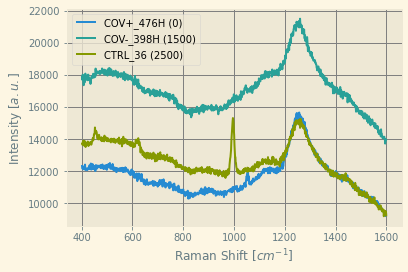

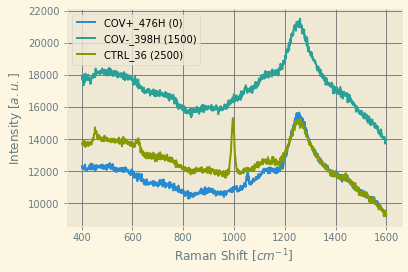

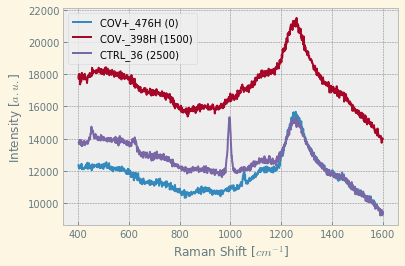

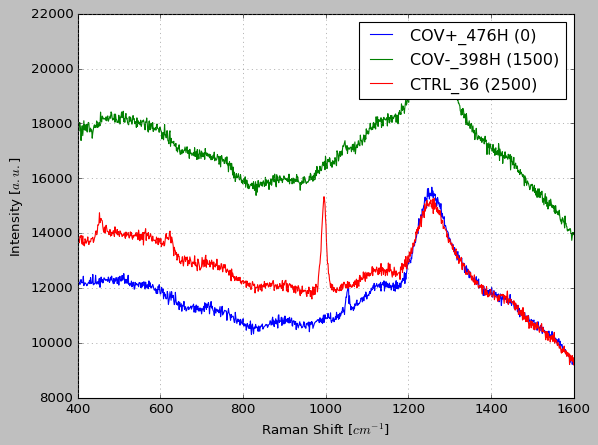

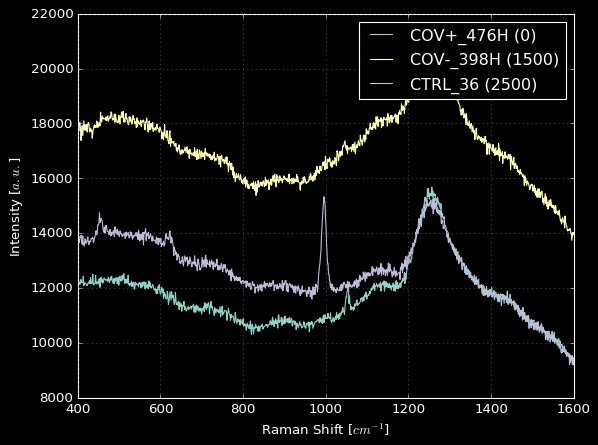

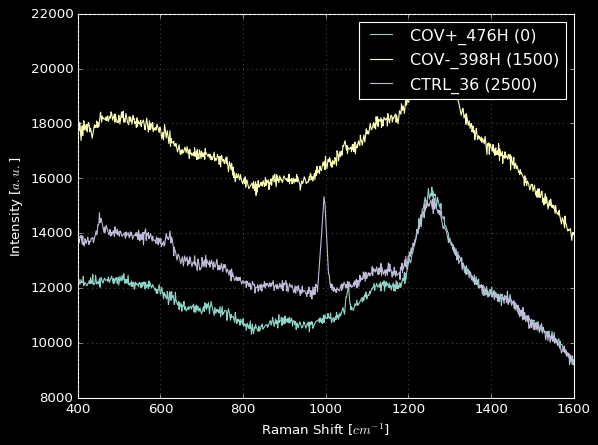

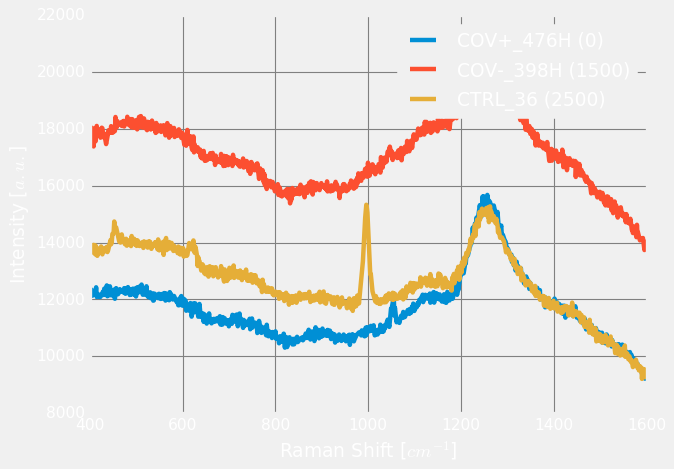

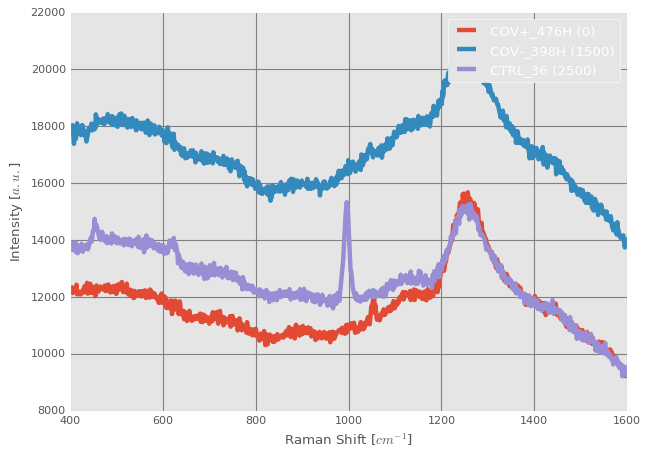

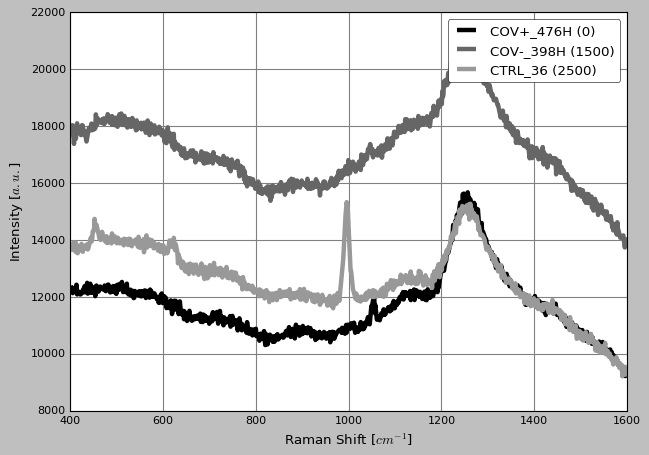

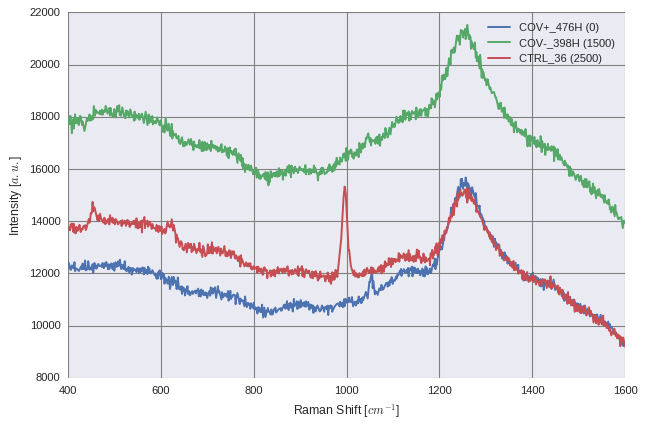

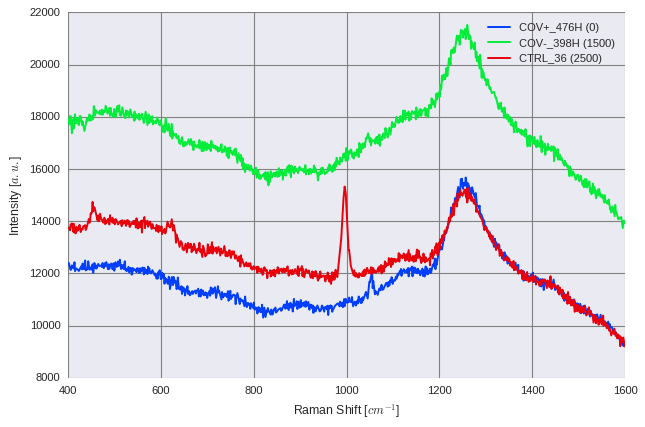

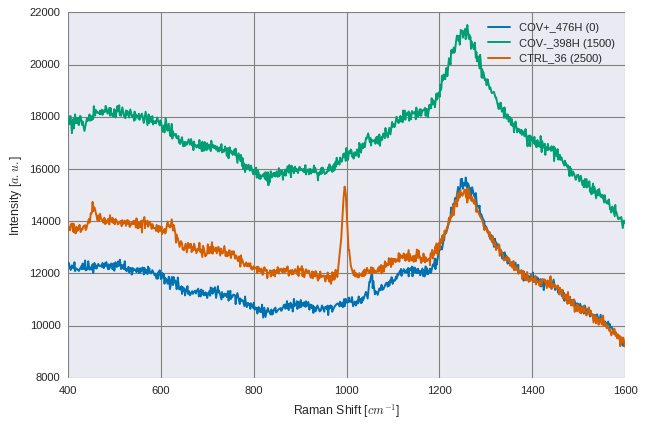

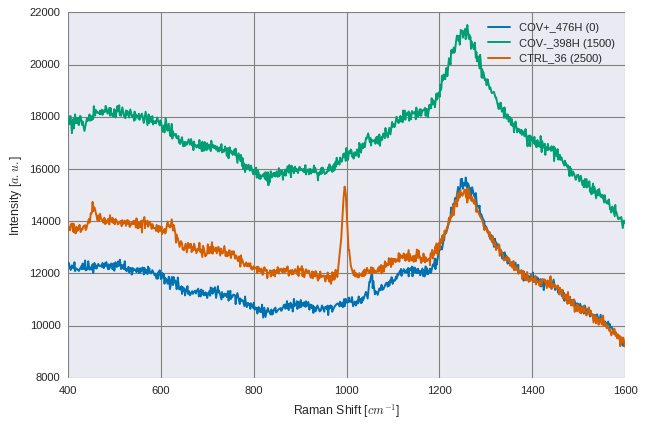

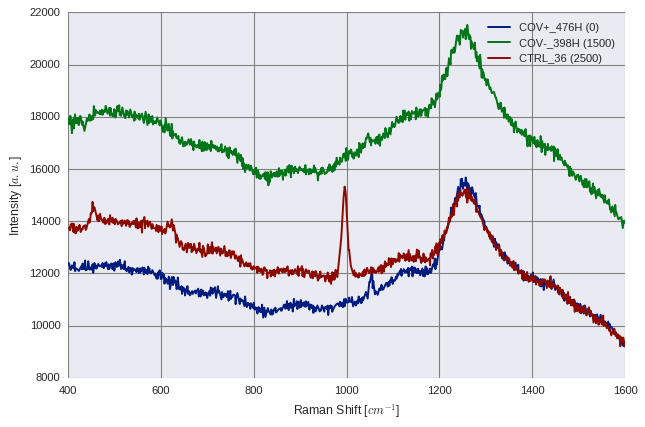

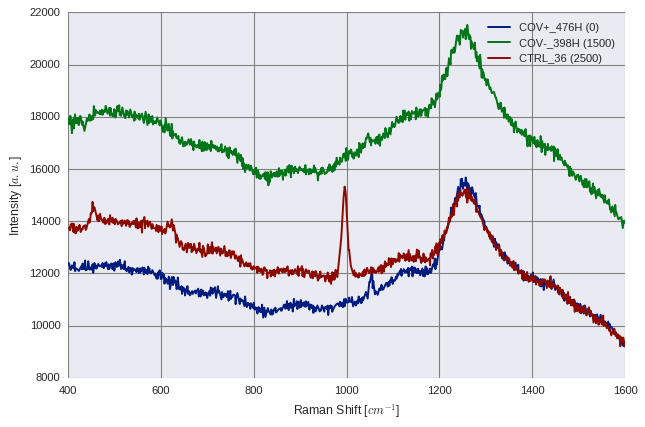

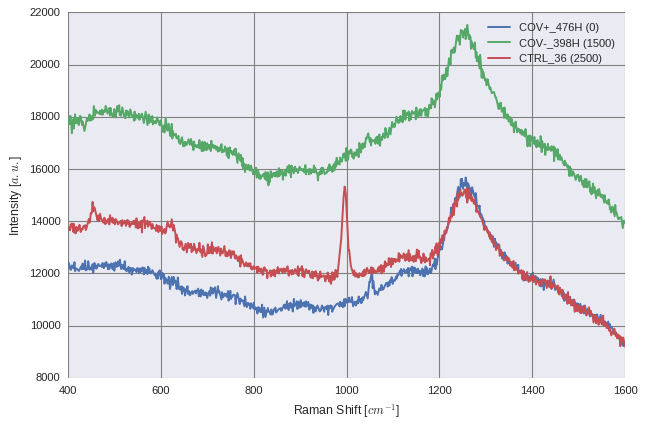

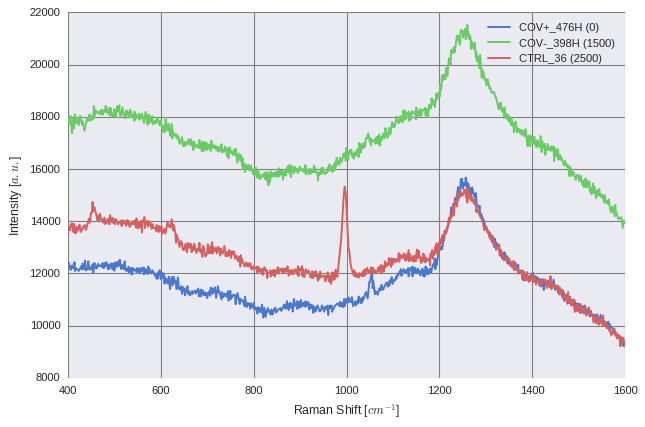

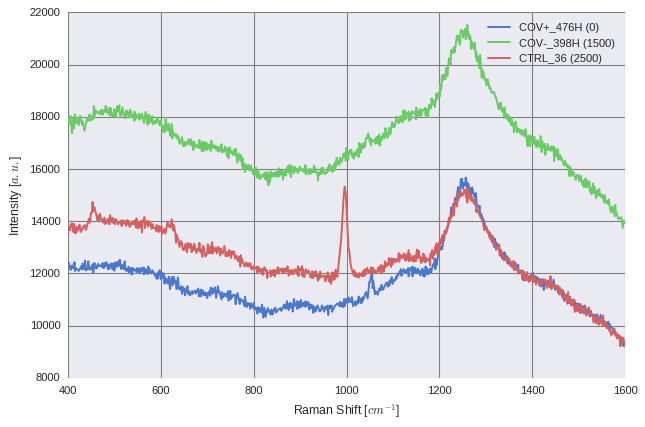

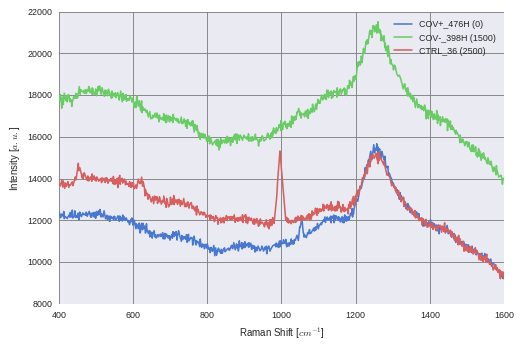

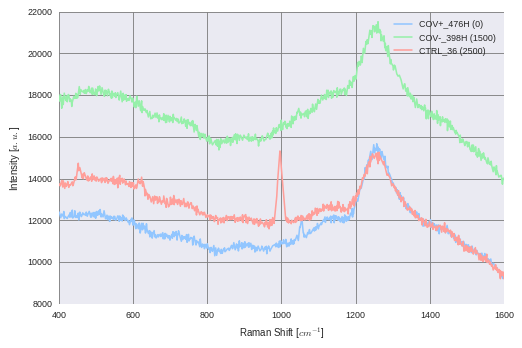

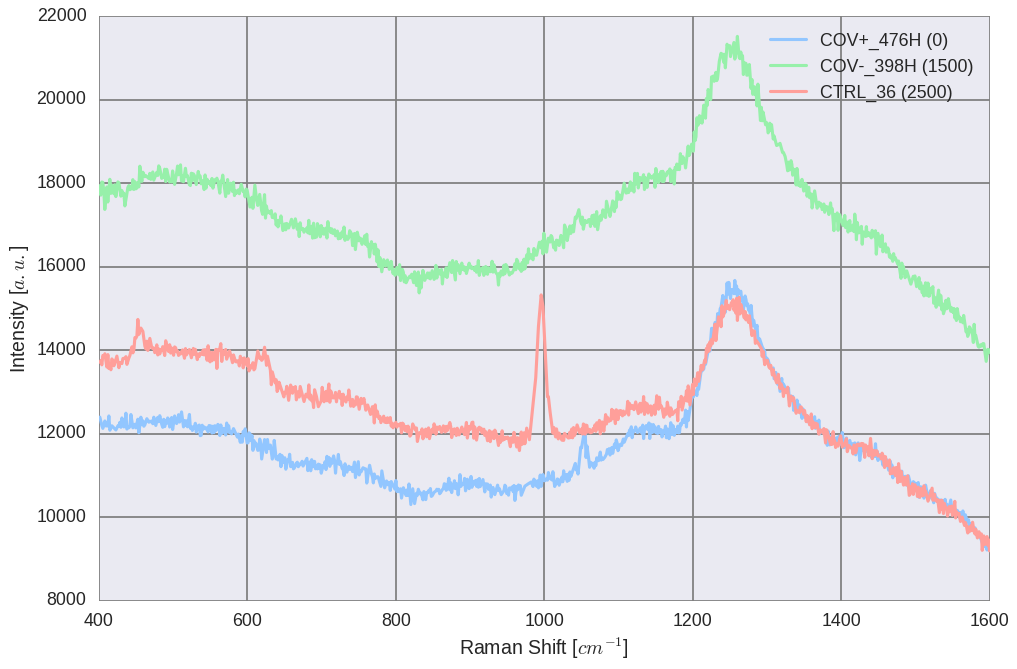

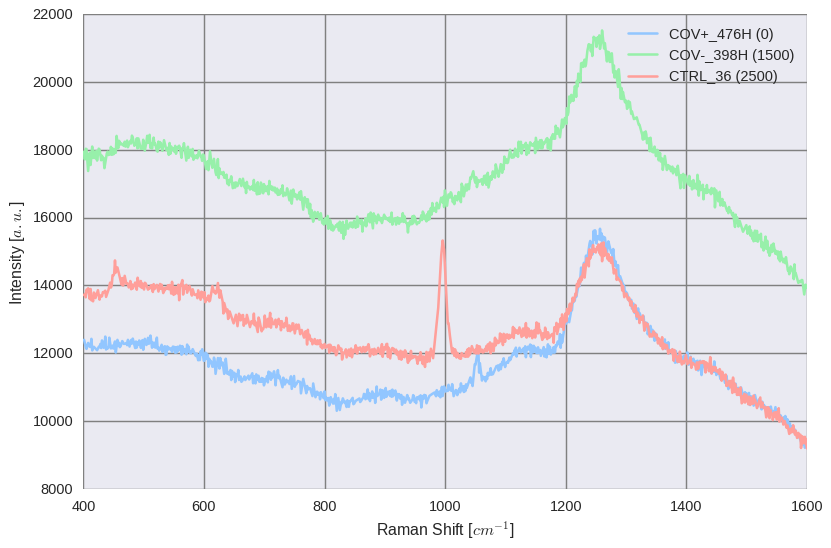

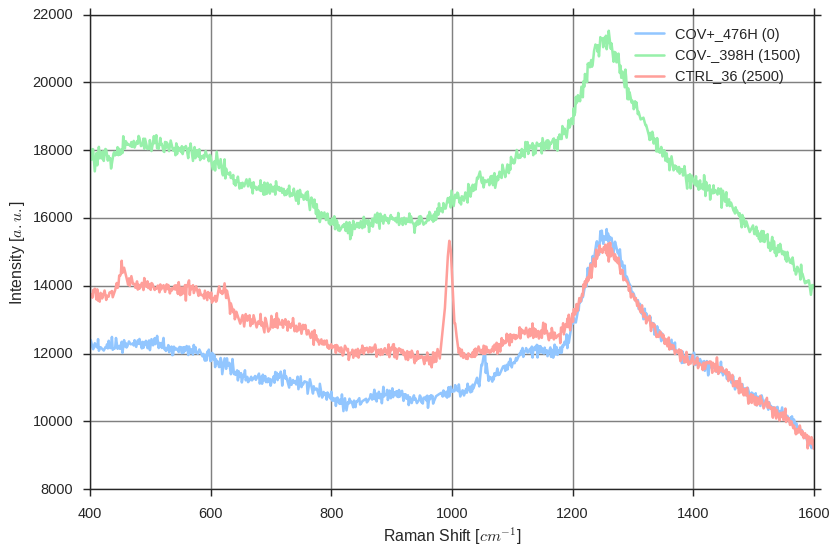

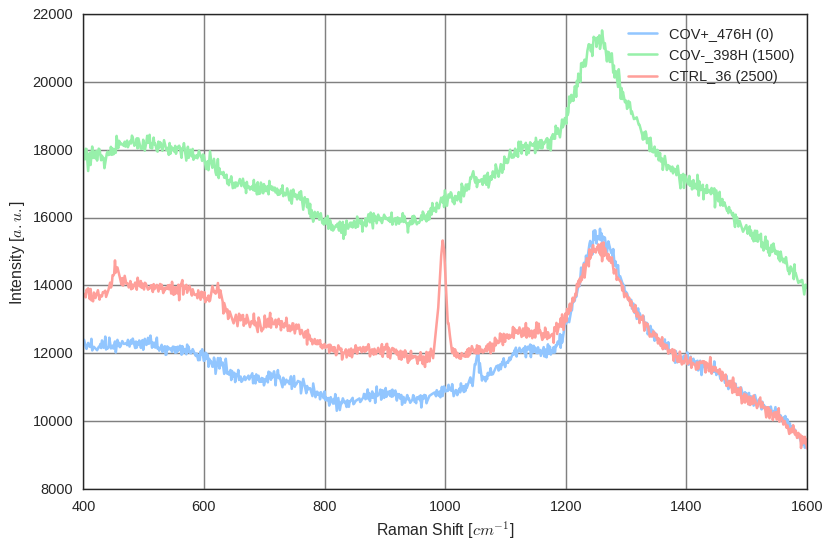

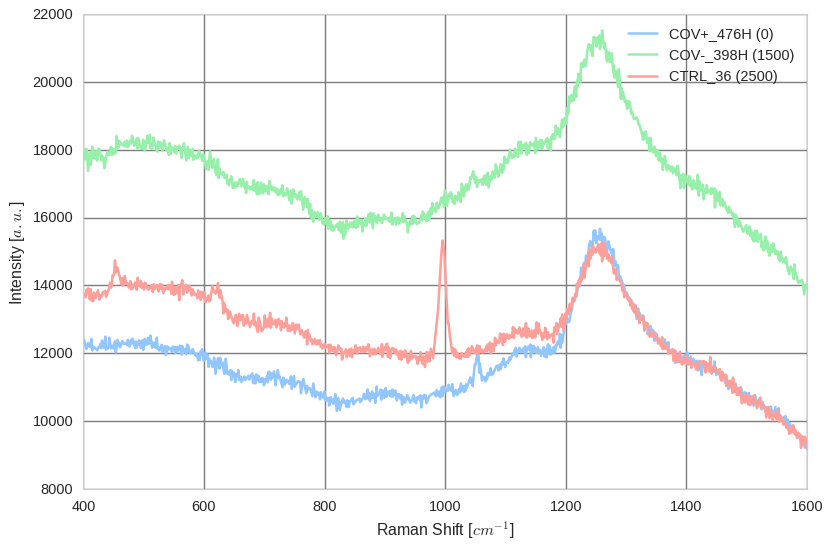

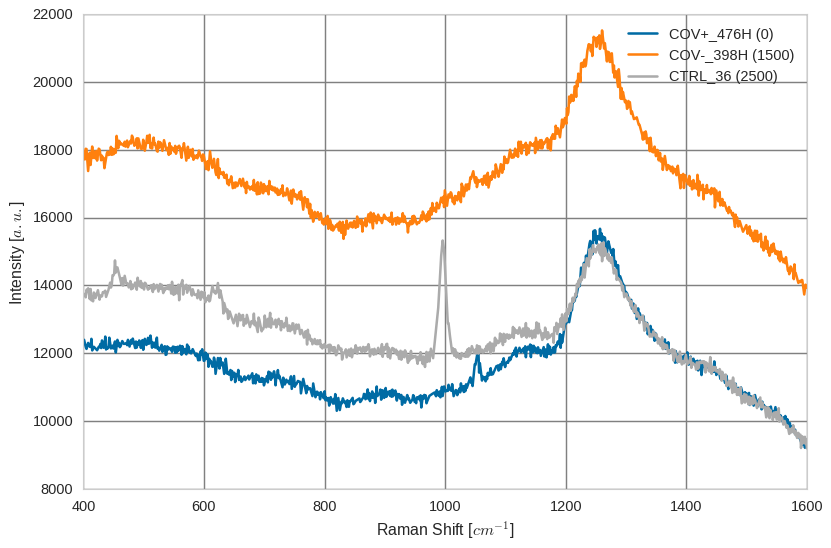

In [ ]:
for i in plt.style.available:
  plt.style.use(i)
  draw_by_index(raw_data_pd, 0)
  draw_by_index(raw_data_pd, 1500)
  draw_by_index(raw_data_pd, 2500)

  plt.grid(color='grey')
  plt.xlabel('Raman Shift [$cm^{-1}$]')
  plt.ylabel('Intensity [$a.u.$]')

  #plt.savefig('category_dataset.pdf')
  plt.show()

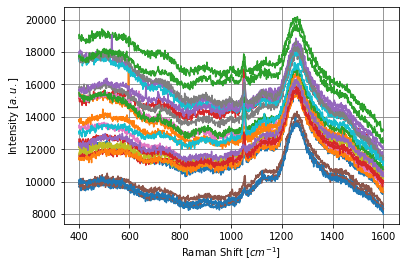

In [ ]:
draw_by_user(raw_data_pd, 'COV+_476H')

plt.grid(color='grey')
plt.xlabel('Raman Shift [$cm^{-1}$]')
plt.ylabel('Intensity [$a.u.$]')

plt.savefig('user_dataset.pdf')
plt.show()

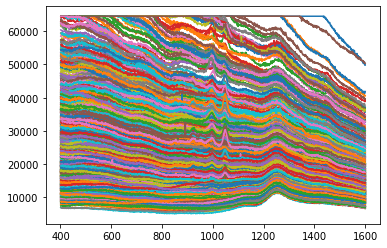

In [ ]:
draw_by_category(raw_data_pd, 'COV-')

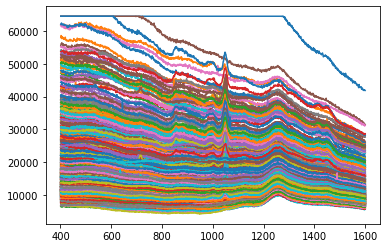

In [ ]:
draw_by_category(raw_data_pd, 'COV+')

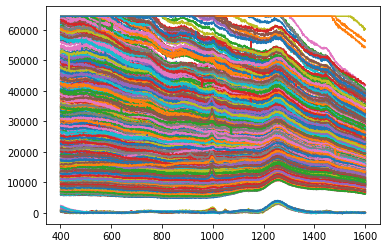

In [ ]:
draw_by_category(raw_data_pd, 'CTRL')

In [ ]:
clean_data2 = get_dataset_no_outliers(raw_data_pd, treshold=400)

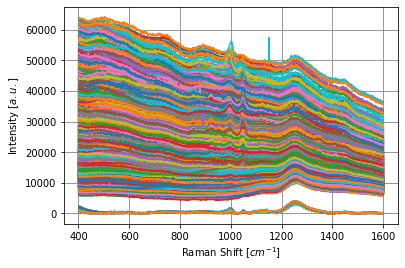

In [ ]:
draw_by_category(clean_data2, 'CTRL')
draw_by_category(clean_data2, 'COV+')
draw_by_category(clean_data2, 'COV-')

plt.grid(color='grey')
plt.xlabel('Raman Shift [$cm^{-1}$]')
plt.ylabel('Intensity [$a.u.$]')

plt.savefig('clean_dataset.png', dpi=300)
plt.show()

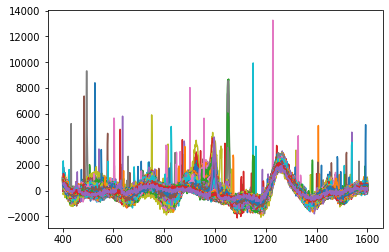

In [ ]:
draw_by_category_fitted(clean_data2, 'CTRL')

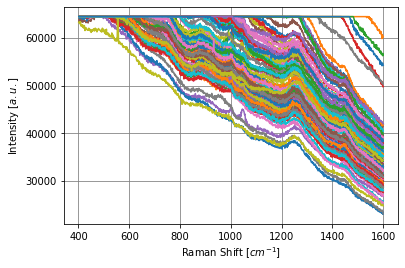

In [ ]:
for idx, i in enumerate(raw_data_pd['spectra']):
  if is_outlier(raw_data_pd, idx, treshold=500):
    draw_by_index(raw_data_pd, idx, draw_legend=False)

plt.grid(color='grey')
plt.xlabel('Raman Shift [$cm^{-1}$]')
plt.ylabel('Intensity [$a.u.$]')

plt.savefig('outsiders.pdf')
plt.show()

In [ ]:
print(f'Nel dataset ci sono **{how_many_outliers(raw_data_pd, treshold=400)}** outliers da eliminare nel preprocessing')

Nel dataset ci sono **107** outliers da eliminare nel preprocessing


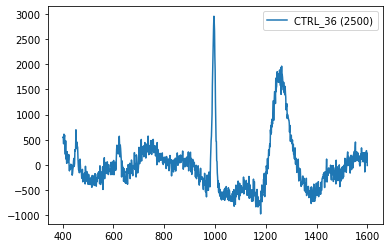

In [ ]:
draw_by_index_fitted(raw_data_pd, 2500)

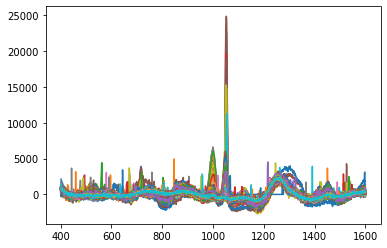

In [ ]:
draw_by_category_fitted(raw_data_pd, 'COV+')

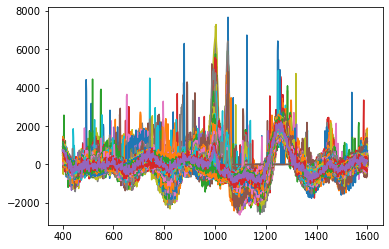

In [ ]:
draw_by_category_fitted(raw_data_pd, 'COV-')

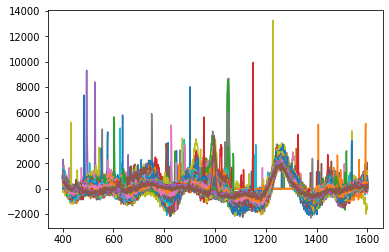

In [ ]:
draw_by_category_fitted(raw_data_pd, 'CTRL')

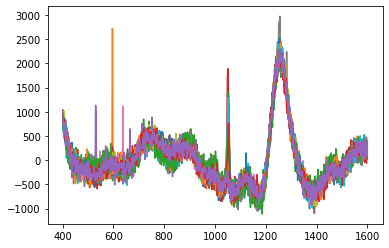

In [ ]:
draw_by_user_fitted(raw_data_pd, 'COV+_476H')

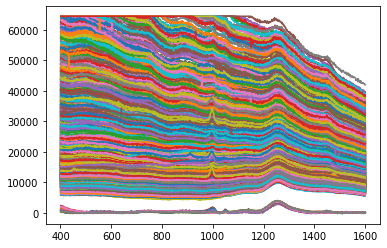

In [ ]:
df = get_dataset_no_outliers(raw_data_pd)
for i in range(len(df)):
    plt.plot(df['x-axis'][i], df['spectra'][i])

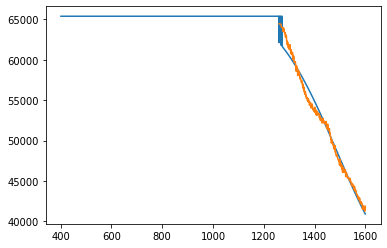

In [ ]:
y = raw_data_pd['spectra'][1300]
my = np.ma.masked_equal(y, 64500)
x = raw_data_pd['x-axis'][1300]
mx = np.ma.masked_where(np.ma.getmask(my), x)

poly = np.polyfit(mx, my, deg=5)

tyu = np.polyval(poly, mx)
plt.plot(x, tyu.filled(64500))
plt.plot(mx.compressed(), my.compressed())

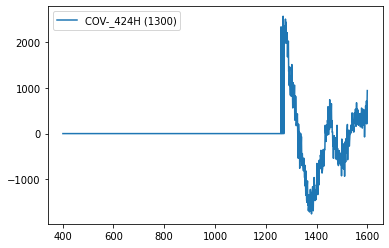

In [ ]:
draw_by_index_fitted(raw_data_pd, 1300)

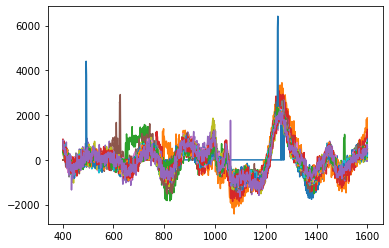

In [ ]:
draw_by_user_fitted(raw_data_pd, 'COV-_424H')

# 1D networks

## Preprocessing (1D)

In [ ]:
def get_preprocessed_data_1d(raw_dataset, train_pr=0.5, val_pr=0.25, test_pr=0.25, augment=False):
  clean_dataset = get_dataset_no_outliers(raw_dataset, treshold=400)

  x_train, y_train, x_val, y_val, x_test, y_test = dataset_split(clean_dataset, 
                                                                 train_pr=train_pr,
                                                                 val_pr=val_pr,
                                                                 test_pr=test_pr)
  x_train = normalize(x_train)
  x_val = normalize(x_val)
  x_test_norm = normalize(x_test)

  divided_spectra = divide_spectra(x_test, x_test_norm, raw_dataset)

  if augment:
    x_train, y_train = data_augmentation(x_train, y_train)
  
  return x_train, y_train, x_val, y_val, x_test, y_test, x_test_norm, divided_spectra

In [ ]:
def get_user(spectra, data, tupled):
  idx = raw_data_pd.index[tupled == tuple(spectra)][0]
  return data['user'][idx]

def divide_spectra(x_test, x_test_norm, data):
  results = {}
  patients = data['user'].unique()
  tupled = raw_data_pd.spectra.map(tuple)
  for p in patients:
    results[p] = []

  for idx, spectra in enumerate(x_test):
    user = get_user(spectra, data, tupled)
    results[user].append(x_test_norm[idx])

  return {k:v for k,v in results.items() if v}

In [ ]:
def get_label(patients):
  
  label=[]
  for p in patients:
    if 'COV+' in p:
      label.append(0)
    
    elif 'COV-' in p:
      label.append(1)
    
    elif 'CTRL' in p:
      label.append(2)

  return label

In [ ]:
def dataset_split(data, train_pr, val_pr, test_pr):

  patients = data['user'].unique()
  val_pr=val_pr*(1+test_pr)
  # x1: train, x2: val, x3: test
  x1, x3 = train_test_split(patients, test_size=test_pr, stratify=get_label(patients))
  x1, x2= train_test_split(x1, test_size=val_pr, stratify=get_label(x1))

  x_train=[]
  x_val=[]
  x_test=[]

  train_users = []
  test_users = []
  val_users = []

  for idx, user in enumerate(raw_data_pd['user']):
    if user in x1:
      x_train.append(raw_data_pd['spectra'][idx])
      train_users.append(raw_data_pd['user'][idx])
    elif user in x2:
      x_val.append(raw_data_pd['spectra'][idx])
      val_users.append(raw_data_pd['user'][idx])
    elif user in x3:
      x_test.append(raw_data_pd['spectra'][idx])
      test_users.append(raw_data_pd['user'][idx])

  y_train=get_label(train_users)
  y_val=get_label(val_users)
  y_test=get_label(test_users)

  y_train = utils.to_categorical(y_train, 3)
  y_test = utils.to_categorical(y_test, 3)
  y_val = utils.to_categorical(y_val, 3)

  x_train = np.array(x_train)
  x_val = np.array(x_val)
  x_test = np.array(x_test)

  return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
def normalize(x):

  new_x=[]

  for spectra in x:
    #new_x.append(spectra/max(spectra))
    new_x.append(spectra/spectra[0])
    #new_x.append(spectra/np.mean(spectra))
    
  return np.array(new_x)

In [ ]:
#gaussian noise

def data_augmentation(x, y, n_spectra=5):
  new_x = []
  new_y = []

  for idx, s in enumerate(x):
    for n in range(n_spectra):
      noise = np.random.normal(0,0.0005,991)
      new_spectra = s+noise
      new_x.append(new_spectra)
      new_y.append(y[idx])

  return np.array(new_x), np.array(new_y)

### Example

In [ ]:
clean_dataset = get_dataset_no_outliers(raw_data_pd, treshold=400)
#clean_dataset = get_dataset_fitted(clean_dataset)

#splitting the dataset
x_train, y_train, x_val, y_val, x_test, y_test = dataset_split(clean_dataset, 
                                                               train_pr=0.5,
                                                               val_pr=0.25,
                                                               test_pr=0.25)

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(1265, 991)
(591, 991)
(645, 991)


In [ ]:
x_train = normalize(x_train)
x_val = normalize(x_val)
x_test_norm = normalize(x_test)

In [ ]:
divided_spectra = divide_spectra(x_test, x_test_norm, raw_data_pd)

In [ ]:
x_train, y_train = data_augmentation(x_train, y_train)

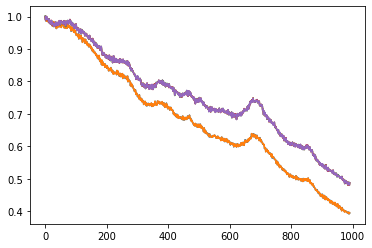

In [ ]:
plt.plot(x_train[-8])
plt.plot(x_train[-7])
plt.plot(x_train[-3])
plt.plot(x_train[-2])
plt.plot(x_train[-1])

## Metrics

In [ ]:
def patients_results(model, spectra_patients, majority=False):
  results = {
    "user": [],
    "prob_cov+": [],
    "prob_cov-": [],
    "prob_ctrl": [],
    "prediction": [],
    "correct_value": []
  }
  for patient in spectra_patients.keys():
    r = model.predict(np.array(spectra_patients[patient]), verbose=0)
    
    if majority:
      r = np.argmax(r, axis=1)
      count=[]

      for i in range(3):
        count.append((r==i).sum())

      pred = np.argmax(count)
    
    else:
      r = r.sum(axis=0)
      r = r / len(spectra_patients[patient])
      pred = r.argmax()
        
    
    if pred == 0:
      pred = 'COV+'
    elif pred == 1:
      pred = 'COV-'
    elif pred == 2:
      pred = 'CTRL'

    if 'COV+' in patient:
      cor = 'COV+'
    elif 'COV-' in patient:
      cor = 'COV-'
    elif 'CTRL' in patient:
      cor = 'CTRL'

    results["user"].append(patient)
    results["prob_cov+"].append(r[0])
    results["prob_cov-"].append(r[1])
    results["prob_ctrl"].append(r[2])
    results["prediction"].append(pred)
    results["correct_value"].append(cor)

  return pd.DataFrame(results)

In [ ]:
def patients_accuracy_tern(results):

  correct = 0

  for idx, _ in enumerate(results['user']):
    if results['prediction'][idx] == results['correct_value'][idx]:
      correct += 1

  return correct/len(results)

def patients_accuracy(results):
  
  correct = 0

  for idx, _ in enumerate(results['user']):

    if results['prediction'][idx]=='COV+':
      if results['correct_value'][idx]=='COV+':
        correct += 1
    else:
      if results['correct_value'][idx] != 'COV+':
        correct+=1

  return correct/len(results)

def patients_sensitivity(results):

  true_positive = 0
  false_negative = 0

  for idx, _ in enumerate(results['user']):
    pred = results['prediction'][idx]
    res = results['correct_value'][idx]
    if pred == 'COV+' and res == 'COV+':
      true_positive += 1
    elif pred != 'COV+' and res == 'COV+':
      false_negative += 1

  try:
    return true_positive/(true_positive+false_negative)
  except:
    return float('NaN')

def patients_specifity(results):

  true_negative = 0
  false_positive = 0

  for idx, _ in enumerate(results['user']):
    pred = results['prediction'][idx]
    res = results['correct_value'][idx]
    if pred != 'COV+' and res != 'COV+':
      true_negative += 1
    elif pred == 'COV+' and res != 'COV+':
      false_positive += 1

  try:
    return true_negative/(true_negative+false_positive)
  except:
    return float('NaN')

In [ ]:
def patients_confusion_matrix(results):

  y_pred = results['prediction']
  y_true = results['correct_value']

  label=['COV+', 'COV-', 'CTRL']

  mat=ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=label)
  mat.plot()
  plt.show()

## LOPOCV

In [ ]:
def divide_patients_in_category(patients):
  cov_p = []
  cov_m = []
  ctrl = []

  for p in patients:
    if 'COV+' in p:
      cov_p.append(p)
    elif 'COV-' in p:
      cov_m.append(p)
    elif 'CTRL' in p:
      ctrl.append(p)
  return cov_p, cov_m, ctrl

In [ ]:
def divide_patients_in_groups(patients, k=1):
  
  cov_p, cov_m, ctrl = divide_patients_in_category(patients)


  random.shuffle(cov_p)
  random.shuffle(cov_m)
  random.shuffle(ctrl)
  
  total_num = len(cov_p) 

  new_k = int(np.floor(k / 3))

  new_division = []

  for i in np.arange(0,total_num, new_k, dtype='int32'):
    temp_y = []
    temp_y.append(cov_p[i:i+new_k])
    temp_y.append(cov_m[i:i+new_k])
    temp_y.append(ctrl[i:i+new_k])

    new_division.append(np.reshape(temp_y, (len(temp_y)*new_k, ) ))
  return new_division

In [ ]:
def get_split_by_names(odataset, test_names):

  dataset = odataset.copy()
  x_test = []
  y_test = []

  x_train = []
  y_train = []

  for idx, name in enumerate(dataset['user']):
    if name in test_names:
      x_test.append(dataset['spectra'][idx])
      y_test.append(name)
    else:
      x_train.append(dataset['spectra'][idx])
      y_train.append(name)

  y_train=get_label(y_train)
  y_test=get_label(y_test)

  return x_train, y_train, x_test, y_test

In [ ]:
def train_lopocv(raw_dataset, make_model, augment=False, k=1):
  dataset = get_dataset_no_outliers(raw_dataset, treshold=400)

  patients = dataset.user.unique()
  division = divide_patients_in_groups(patients, k)

  accuracies_tern = []
  accuracies = []
  sensitivity = []
  specificity = []

  for idx, testset in enumerate(division):
    x_train, y_train, x_test, y_test = get_split_by_names(dataset, testset)

    x_train = normalize(np.array(x_train))
    x_test_norm = normalize(np.array(x_test))

    divided_spectra = divide_spectra(x_test, x_test_norm, raw_dataset)

    if augment:
      x_train, y_train = data_augmentation(x_train, y_train)
  
    y_train = utils.to_categorical(y_train, 3)
    y_test = utils.to_categorical(y_test, 3)

    x_train = np.array(x_train)
    x_test = np.array(x_test)


    batch_size = 28
    n_epochs = 150
    
    checkpoint_path = '/tmp/checkpoint' 
    model_checkpoint_callback = ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,
      monitor='val_categorical_accuracy',
      mode='max',
      save_best_only=True)
  
    model_earlystopping_callback = EarlyStopping(
      monitor='categorical_accuracy',
      min_delta=0.01,
      patience=50,
      verbose=1
    )

    clear_session()
    model = make_model(dropout=True)
    network_history = model.fit(x_train, y_train, batch_size=batch_size, 
                                callbacks=[model_checkpoint_callback,
                                           model_earlystopping_callback],
                                epochs=n_epochs, verbose=0,
                                validation_data=(x_test, y_test))
    model.load_weights(checkpoint_path)
    #plot_history(network_history, False)
  
    df_res = patients_results(model, divided_spectra)

    accuracies_tern.append(patients_accuracy_tern(df_res))
    accuracies.append(patients_accuracy(df_res))
    sensitivity.append(patients_sensitivity(df_res))
    specificity.append(patients_specifity(df_res))

    print(f'\nIterazione {idx}')
    print(f'\tTestAcc={patients_accuracy(df_res)}')
    print(f'\tTrainAcc={network_history.history["categorical_accuracy"][-1]}')
    print(df_res)

  return accuracies_tern, accuracies, sensitivity, specificity

In [ ]:
#model = make_conv_model(dropout=True)
acc_tern, acc, sens, spec = train_lopocv(raw_data_pd, make_conv_model, k=3)
print('\n\n')
print(acc_tern)
print(acc)
print(sens)
print(spec)
print(f'\nAcc_tern: {np.mean(acc_tern)}')
print(f'Acc: {np.mean(acc)}')
print(f'Sens: {np.mean(sens)}')
print(f'Spec: {np.mean(spec)}')

Epoch 91: early stopping

Iterazione 0
	TestAcc=0.6666666666666666
	TrainAcc=0.4530172348022461
        user  prob_cov+  prob_cov-  prob_ctrl prediction correct_value
0  COV+_457H   0.273133   0.416951   0.309915       COV-          COV+
1   COV-_61H   0.260479   0.423963   0.315558       COV-          COV-
2    CTRL_35   0.316086   0.384836   0.299078       COV-          CTRL
Epoch 113: early stopping

Iterazione 1
	TestAcc=0.6666666666666666
	TrainAcc=0.4926724135875702
        user  prob_cov+  prob_cov-  prob_ctrl prediction correct_value
0    COV+_07   0.385510   0.286055   0.328435       COV+          COV+
1  COV-_451H   0.479212   0.204963   0.315824       COV+          COV-
2    CTRL_16   0.182282   0.410494   0.407224       COV-          CTRL
Epoch 87: early stopping

Iterazione 2
	TestAcc=0.6666666666666666
	TrainAcc=0.4480379521846771
        user  prob_cov+  prob_cov-  prob_ctrl prediction correct_value
0  COV+_469H   0.249989   0.437354   0.312656       COV-          COV+
1

In [ ]:
print(np.mean(acc_tern))
print(np.mean(acc))
print(np.mean(sens))
print(np.mean(spec))

0.5777777777777777
0.7222222222222222
0.4666666666666667
0.85


## Convolutional NN (con GaussianNoise)

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test, x_test_norm, divided_spectra = get_preprocessed_data_1d(raw_data_pd,
                                                                                                        augment=False)

print(np.shape(x_train))
print(np.shape(y_train))

print(np.shape(x_val))
print(np.shape(y_val))

print(np.shape(x_test))
print(np.shape(y_test))

(1270, 991)
(1270, 3)
(595, 991)
(595, 3)
(636, 991)
(636, 3)


In [ ]:
def make_conv_model(input_dim = 991, optimizer = 'adam', activation='relu', initializer='glorot_uniform',
                       loss = 'categorical_crossentropy', metrics = 'categorical_accuracy',
                       dropout=False):

  input = Input(shape=(input_dim,1))

  gaussian = GaussianNoise(0.05)(input)

  conv_1 = Conv1D(100, kernel_size=100, strides=1, activation=activation, name = "conv_1", kernel_initializer=initializer)(input)
  conv_2 = Conv1D(100, kernel_size=5, strides=2, activation=activation, name = "conv_2", kernel_initializer=initializer)(conv_1)
  maxpool_1 = MaxPool1D(pool_size=6, strides=3, name = "maxpool_1")(conv_2)
  conv_3 = Conv1D(25, kernel_size=9, strides=5, activation=activation, name = "conv_3", kernel_initializer=initializer)(maxpool_1)
  maxpool_2 = MaxPool1D(pool_size=3, strides=2, name = "maxpool_2")(conv_3)
  
  flatten = Flatten()(maxpool_2)
  #flatten = GaussianNoise(0.05)(flatten)

  if dropout:
    flatten = Dropout(0.2)(flatten)
  dense_1 = Dense(732, activation=activation, name = "dense_1", kernel_initializer=initializer)(flatten)
  #dense_1 = GaussianNoise(0.05)(dense_1)
  
  if dropout:
    dense_1 = Dropout(0.2)(dense_1)
  dense_2 = Dense(189, activation=activation, name = "dense_2", kernel_initializer=initializer)(dense_1)
  if dropout:
    dense_2 = Dropout(0.2)(dense_2)
  dense_3 = Dense(152, activation=activation, name = "dense_3", kernel_initializer=initializer)(dense_2)

  output = Dense(3, activation="softmax", name = "output")(dense_3)

  model = Model(input, output)

  model.compile(optimizer = optimizer, loss = loss, metrics = [metrics])  
    
  return model

In [ ]:
conv_model = make_conv_model(dropout=True)
conv_model.summary()

checkpoint_path = '/tmp/checkpoint' 
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

model_earlystopping_callback = EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0.01,
    patience=20,
    verbose=1
)



batch_size = 28
n_epochs = 20

network_history = conv_model.fit(x_train, y_train, batch_size=batch_size, 
                                 epochs=n_epochs, verbose=1,
                                 callbacks=[model_checkpoint_callback],
                                 validation_data=(x_val, y_val))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 991, 1)]          0         
                                                                 
 conv_1 (Conv1D)             (None, 892, 100)          10100     
                                                                 
 conv_2 (Conv1D)             (None, 444, 100)          50100     
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 147, 100)          0         
                                                                 
 conv_3 (Conv1D)             (None, 28, 25)            22525     
                                                                 
 maxpool_2 (MaxPooling1D)    (None, 13, 25)            0         
                                                                 
 flatten_2 (Flatten)         (None, 325)               0   

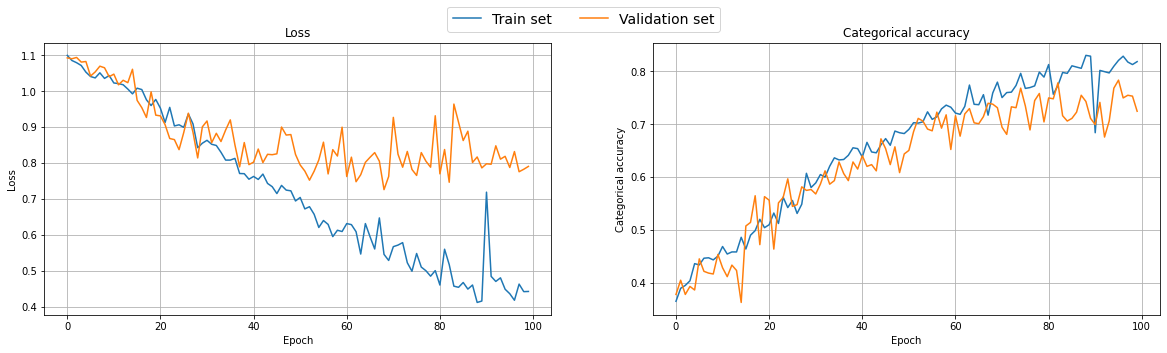

At the 100 th epoch: 

The loss: 0.4420487880706787
The categorical_accuracy 0.8181818127632141
The val_loss: 0.7903944849967957
The val_categorical_accuracy: 0.7243697643280029


In [ ]:
plot_history(network_history)

In [ ]:
conv_model.load_weights(checkpoint_path)

In [ ]:
test_results = conv_model.evaluate(x_test_norm, y_test, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

21/21 [==============================] - 0s 5ms/step - loss: 0.7908 - categorical_accuracy: 0.7223
Test results - Loss: 0.7907953262329102 - Accuracy: 0.722308874130249


0.8076923076923077
0.375
1.0


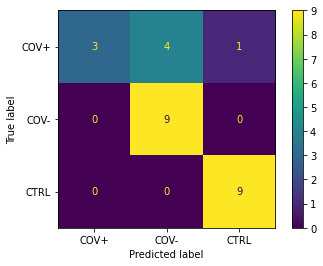

In [ ]:
df_res = patients_results(conv_model, divided_spectra)

print(patients_accuracy(df_res))
print(patients_sensitivity(df_res))
print(patients_specifity(df_res))
patients_confusion_matrix(df_res)

0.6923076923076923
0.0
1.0


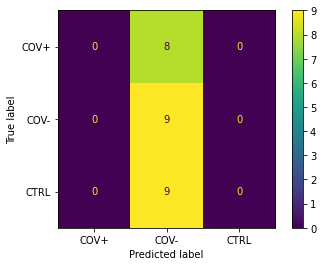

In [ ]:
df_res = patients_results(conv_model, divided_spectra, majority= False)

print(patients_accuracy(df_res))
print(patients_sensitivity(df_res))
print(patients_specifity(df_res))
patients_confusion_matrix(df_res)

In [ ]:
df_res

user  prob_cov+  prob_cov-  prob_ctrl  prediction correct_value
0     COV+_31          1          1          1          25          COV+
1     COV+_28          1          1          1          25          COV+
2     COV+_30          1          1          1          25          COV+
3     COV+_05          1          1          1          25          COV+
4   COV+_454H          1          1          1          25          COV+
5   COV+_422H          1          1          1          25          COV+
6     COV+_10          1          1          1          25          COV+
7   COV+_477H          1          1          1          25          COV+
8   COV-_467H          1          1          1          25          COV-
9   COV-_422H          1          1          1          25          COV-
10   COV-_61H          1          1          1          25          COV-
11    COV-_18          1          1          1          25          COV-
12    COV-_27          1          1          1          25          COV-
13  COV-_424H          1          1          1          25          COV-
14    COV-_22          1          1          1          25          COV-
15  COV-_451H          1          1          1          25          COV-
16  COV-_450H          1          1          1          25          COV-
17    CTRL_08          1          1          1          20          CTRL
18    CTRL_27          1          1          1          25          CTRL
19    CTRL_30          1          1          1          25          CTRL
20    CTRL_23          1          1          1          25          CTRL
21    CTRL_01          1          1          1          16          CTRL
22    CTRL_35          1          1          1          25          CTRL
23    CTRL_28          1          1          1          25          CTRL
24    CTRL_03          1          1          1          25          CTRL
25    CTRL_09          1          1          1          25          CTRL

## Convolutional NN (benchmark)

In [ ]:
def make_conv_model(input_dim = None, optimizer = 'adam', activation= 'relu',
                       loss = 'categorical_crossentropy', metrics = 'categorical_accuracy',
                       dropout=False):

  input = Input(shape=(input_dim,1))

  conv_1 = Conv1D(100, kernel_size=100, strides=1, activation=activation, name = "conv_1")(input)
  conv_2 = Conv1D(100, kernel_size=5, strides=2, activation=activation, name = "conv_2")(conv_1)
  maxpool_1 = MaxPool1D(pool_size=6, strides=3, name = "maxpool_1")(conv_2)
  conv_3 = Conv1D(25, kernel_size=9, strides=5, activation=activation, name = "conv_3")(maxpool_1)
  maxpool_2 = MaxPool1D(pool_size=3, strides=2, name = "maxpool_2")(conv_3)
  
  flatten = Flatten()(maxpool_2)
  if dropout:
    flatten = Dropout(0.3)(flatten)
  dense_1 = Dense(732, activation=activation, name = "dense_1")(flatten)
  if dropout:
    dense_1 = Dropout(0.3)(dense_1)
  dense_2 = Dense(189, activation=activation, name = "dense_2")(dense_1)
  if dropout:
    dense_2 = Dropout(0.3)(dense_2)
  dense_3 = Dense(152, activation=activation, name = "dense_3")(dense_2)

  output = Dense(3, activation="softmax", name = "output")(dense_3)

  model = Model(input, output)

  model.compile(optimizer = optimizer, loss = loss, metrics = [metrics])  
    
  return model

In [ ]:
conv_model = make_conv_model(991)
conv_model.summary()

batch_size = 128
n_epochs = 50

network_history = conv_model.fit(x_train, y_train, batch_size=batch_size, 
                                  epochs=n_epochs, verbose=1,
                                  validation_data=(x_val, y_val))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 991, 1)]          0         
                                                                 
 conv_1 (Conv1D)             (None, 892, 100)          10100     
                                                                 
 conv_2 (Conv1D)             (None, 444, 100)          50100     
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 147, 100)          0         
                                                                 
 conv_3 (Conv1D)             (None, 28, 25)            22525     
                                                                 
 maxpool_2 (MaxPooling1D)    (None, 13, 25)            0         
                                                                 
 flatten_2 (Flatten)         (None, 325)               0   

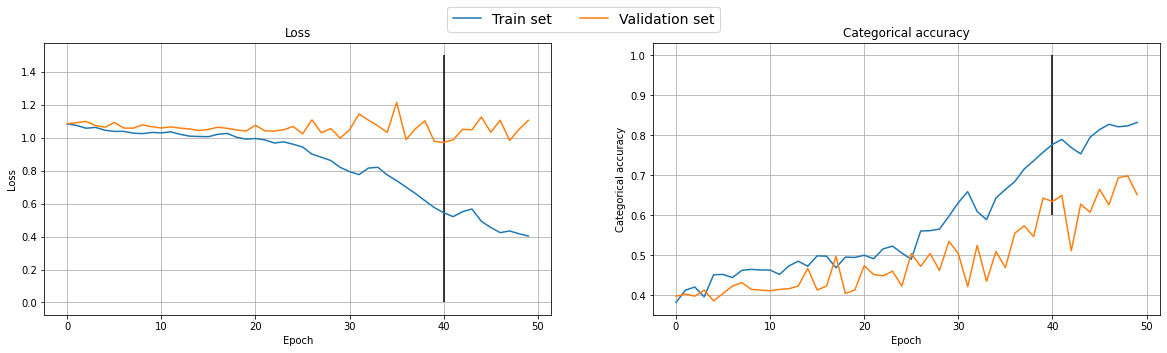

At the 50 th epoch: 

The val_loss: 1.1054396629333496
The loss: 0.40278705954551697
The val_categorical_accuracy: 0.6514382362365723
The categorical_accuracy 0.8322834372520447


In [ ]:
plot_history(network_history)

In [ ]:
test_results = conv_model.evaluate(x_test_norm, y_test, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

20/20 [==============================] - 0s 7ms/step - loss: 1.0280 - categorical_accuracy: 0.7109
Test results - Loss: 1.0279805660247803 - Accuracy: 0.7109375


0.7307692307692307
0.375
0.9444444444444444


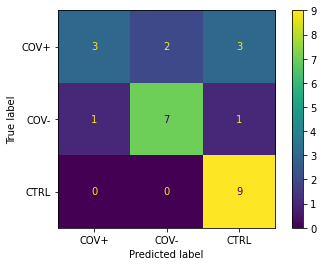

In [ ]:
df_res = patients_results(conv_model, divided_spectra)

print(patients_accuracy(df_res))
print(patients_sensitivity(df_res))
print(patients_specifity(df_res))
patients_confusion_matrix(df_res)

In [ ]:
#dropout

conv_model_dropout = make_conv_model(991, dropout=True)
conv_model_dropout.summary()

batch_size = 128
n_epochs = 100

network_history2 = conv_model_dropout.fit(x_train, y_train, batch_size=batch_size, 
                                  epochs=n_epochs, verbose=1,
                                  validation_data=(x_val, y_val))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 991, 1)]          0         
                                                                 
 conv_1 (Conv1D)             (None, 892, 100)          10100     
                                                                 
 conv_2 (Conv1D)             (None, 444, 100)          50100     
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 147, 100)          0         
                                                                 
 conv_3 (Conv1D)             (None, 28, 25)            22525     
                                                                 
 maxpool_2 (MaxPooling1D)    (None, 13, 25)            0         
                                                                 
 flatten_4 (Flatten)         (None, 325)               0   

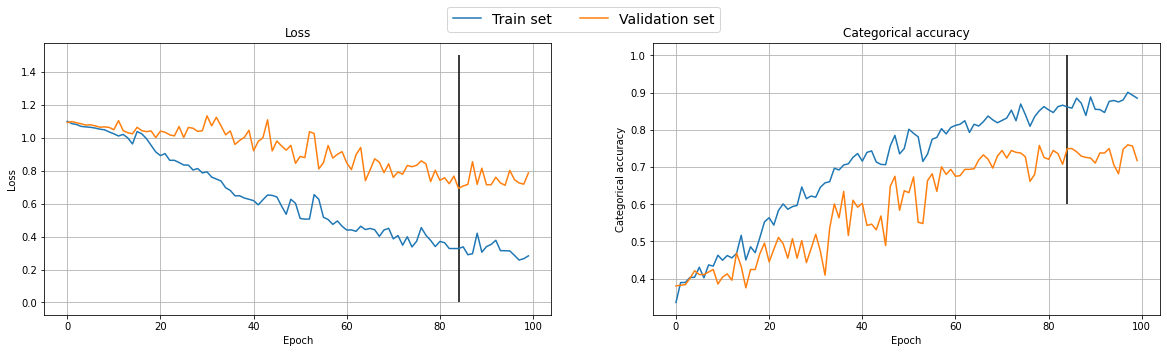

At the 100 th epoch: 

The val_loss: 0.7863600254058838
The loss: 0.2827129065990448
The val_categorical_accuracy: 0.7174280881881714
The categorical_accuracy 0.8850393891334534


In [ ]:
plot_history(network_history2)

In [ ]:
test_results = conv_model_dropout.evaluate(x_test, y_test, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

20/20 [==============================] - 0s 5ms/step - loss: 34827.4883 - categorical_accuracy: 0.4563
Test results - Loss: 34827.48828125 - Accuracy: 0.45625001192092896


0.8076923076923077
0.75
0.9444444444444444


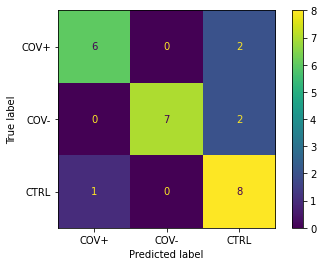

In [ ]:
df_res = patients_results(conv_model_dropout, divided_spectra)

print(patients_accuracy(df_res))
print(patients_sensitivity(df_res))
print(patients_specifity(df_res))
patients_confusion_matrix(df_res)

In [ ]:
r=[[1,2,3],[6,5,4], [7,8,9]]

In [ ]:
r=np.argmax(r, axis=1)
r

array([2, 0, 2])

In [ ]:
count_z = (r == 0).sum()
count_d = (r == 2).sum()

In [ ]:
count_z

1

In [ ]:
pred = r.argmax()
pred

0

## ResNet (con GaussianNoise e shorter)

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test, x_test_norm, divided_spectra = get_preprocessed_data_1d(raw_data_pd)

In [ ]:
def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size = 3):
    y = Conv1D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv1D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net1D():
    
    inputs = Input(shape=(991, 1))
    num_filters = 64

    gaussian = GaussianNoise(0.04)(inputs)
    
    t = BatchNormalization()(gaussian)
    t = Conv1D(kernel_size=7,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    t = MaxPool1D(2)(t)
    
    #num_blocks_list = [3, 4, 6, 3]
    num_blocks_list = [2, 2, 2, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling1D(4)(t)
    t = Flatten()(t)
    outputs = Dense(3, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model

In [ ]:
model=create_res_net1D()
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 991, 1)]     0           []                               
                                                                                                  
 gaussian_noise_16 (GaussianNoi  (None, 991, 1)      0           ['input_17[0][0]']               
 se)                                                                                              
                                                                                                  
 batch_normalization_132 (Batch  (None, 991, 1)      4           ['gaussian_noise_16[0][0]']      
 Normalization)                                                                                   
                                                                                           

In [ ]:
batch_size = 64
n_epochs = 60

network_history = model.fit(x_train, y_train, batch_size=batch_size, 
                                  epochs=n_epochs, verbose=1,
                                  validation_data=(x_val, y_val))

Epoch 1/60
20/20 [==============================] - 7s 146ms/step - loss: 1.4897 - categorical_accuracy: 0.4236 - val_loss: 1.1224 - val_categorical_accuracy: 0.3993
Epoch 2/60
20/20 [==============================] - 2s 98ms/step - loss: 1.3722 - categorical_accuracy: 0.4583 - val_loss: 1.2287 - val_categorical_accuracy: 0.3174
Epoch 3/60
20/20 [==============================] - 2s 97ms/step - loss: 1.3210 - categorical_accuracy: 0.4606 - val_loss: 1.2279 - val_categorical_accuracy: 0.3157
Epoch 4/60
20/20 [==============================] - 2s 98ms/step - loss: 1.1840 - categorical_accuracy: 0.4630 - val_loss: 1.1757 - val_categorical_accuracy: 0.3157
Epoch 5/60
20/20 [==============================] - 2s 102ms/step - loss: 1.1853 - categorical_accuracy: 0.4898 - val_loss: 1.1251 - val_categorical_accuracy: 0.3038
Epoch 6/60
20/20 [==============================] - 2s 98ms/step - loss: 1.0649 - categorical_accuracy: 0.5402 - val_loss: 1.4955 - val_categorical_accuracy: 0.3908
Epoch 7/

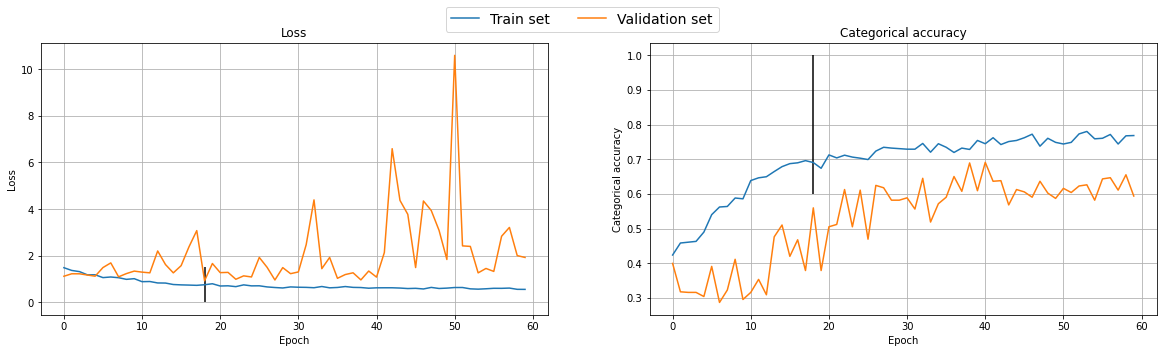

At the 60 th epoch: 

The loss: 0.5599903464317322
The categorical_accuracy 0.7685039639472961
The val_loss: 1.928523063659668
The val_categorical_accuracy: 0.5938566327095032


In [ ]:
plot_history(network_history)

In [ ]:
test_results = model.evaluate(x_test_norm, y_test, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

21/21 [==============================] - 1s 24ms/step - loss: 1.1762 - categorical_accuracy: 0.6527
Test results - Loss: 1.176247477531433 - Accuracy: 0.6527131795883179


0.7307692307692307
0.875
0.9444444444444444


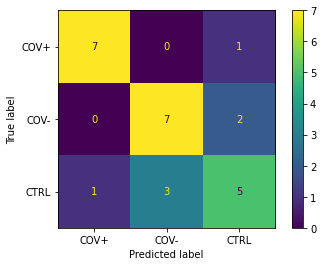

In [ ]:
df_res = patients_results(model, divided_spectra)

print(patients_accuracy(df_res))
print(patients_sensitivity(df_res))
print(patients_specifity(df_res))
patients_confusion_matrix(df_res)

## ResNet

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test, x_test_norm, divided_spectra = get_preprocessed_data_1d(raw_data_pd,
                                                                                                        augment=True)
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))
print(np.shape(x_val))
print(np.shape(y_val))

(6305, 991)
(6305, 3)
(650, 991)
(650, 3)
(590, 991)
(590, 3)


In [ ]:
def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size = 3):
    y = Conv1D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv1D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net1D():
    
    inputs = Input(shape=(991, 1))
    num_filters = 64
    
    gaussian = GaussianNoise(0.01)(inputs)
    t = BatchNormalization()(gaussian)
    t = Conv1D(kernel_size=10,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    t = MaxPool1D(2)(t)
    
    num_blocks_list = [5, 4]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling1D(4)(t)
    t = Flatten()(t)
    outputs = Dense(3, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model

In [ ]:
model=create_res_net1D()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 991, 1)]     0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 991, 1)      0           ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 991, 1)      4           ['gaussian_noise[0][0]']         
 alization)                                                                                       
                                                                                                  
 conv1d (Conv1D)                (None, 991, 64)      704         ['batch_normalization[0][0]']

In [ ]:
batch_size = 128
n_epochs = 10

network_history = model.fit(x_train, y_train, batch_size=batch_size, 
                                  epochs=n_epochs, verbose=1,
                                  validation_data=(x_val, y_val))

Epoch 1/10
50/50 [==============================] - 24s 320ms/step - loss: 1.1920 - categorical_accuracy: 0.4343 - val_loss: 1.1817 - val_categorical_accuracy: 0.3814
Epoch 2/10
50/50 [==============================] - 15s 296ms/step - loss: 1.1371 - categorical_accuracy: 0.4763 - val_loss: 1.1239 - val_categorical_accuracy: 0.3712
Epoch 3/10
50/50 [==============================] - 15s 300ms/step - loss: 0.9613 - categorical_accuracy: 0.5400 - val_loss: 1.2084 - val_categorical_accuracy: 0.3847
Epoch 4/10
50/50 [==============================] - 15s 302ms/step - loss: 0.8937 - categorical_accuracy: 0.5979 - val_loss: 1.3508 - val_categorical_accuracy: 0.3864
Epoch 5/10
50/50 [==============================] - 15s 301ms/step - loss: 0.8694 - categorical_accuracy: 0.6503 - val_loss: 1.3370 - val_categorical_accuracy: 0.4017
Epoch 6/10
50/50 [==============================] - 15s 302ms/step - loss: 0.8622 - categorical_accuracy: 0.6850 - val_loss: 1.3748 - val_categorical_accuracy: 0.437

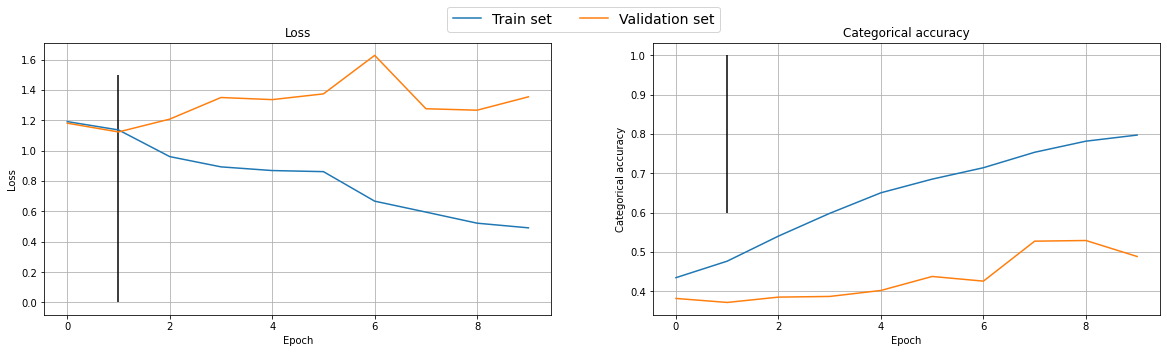

At the 10 th epoch: 

The loss: 0.4917750060558319
The categorical_accuracy 0.7971451282501221
The val_loss: 1.3553996086120605
The val_categorical_accuracy: 0.48813560605049133


In [ ]:
plot_history(network_history)

In [ ]:
test_results = model.evaluate(x_test_norm, y_test, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

21/21 [==============================] - 1s 33ms/step - loss: 1.3789 - categorical_accuracy: 0.4969
Test results - Loss: 1.3789091110229492 - Accuracy: 0.4969230890274048


0.5769230769230769
0.125
0.9444444444444444


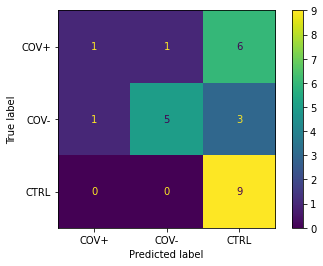

In [ ]:
df_res = patients_results(model, divided_spectra)

print(patients_accuracy(df_res))
print(patients_sensitivity(df_res))
print(patients_specifity(df_res))
patients_confusion_matrix(df_res)

### Hyperband

In [ ]:
def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size = 3):
    y = Conv1D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv1D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [ ]:
def create_res_net1D_hp(hp):

  num_filters = 64 #hp.Int('num_filters', min_value=12, max_value=64, step=12)

  num1 = hp.Int('num1', min_value=1, max_value=5, step=1)
  num2 = hp.Int('num2', min_value=1, max_value=5, step=1)
  #num3 = hp.Int('num3', min_value=1, max_value=5, step=1)
  #num4 = hp.Int('num4', min_value=1, max_value=5, step=1)

  gaus = hp.Float('gaus', min_value=0., max_value=0.1, step=0.005)
  kern_size = hp.Int('kern_size', min_value=5, max_value=11, step=1)

  num_blocks_list = [num1, num2] #, num3, num4]

  
  inputs = Input(shape=(991, 1))

  gaussian = GaussianNoise(gaus)(inputs)
  
  t = BatchNormalization()(gaussian)
  t = Conv1D(kernel_size=kern_size,
              strides=1,
              filters=num_filters,
              padding="same")(t)
  t = relu_bn(t)
  
  t = MaxPool1D(2)(t)
  
  
  for i in range(len(num_blocks_list)):
      num_blocks = num_blocks_list[i]
      for j in range(num_blocks):
          t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
      num_filters *= 2
  
  t = AveragePooling1D(4)(t)
  t = Flatten()(t)
  outputs = Dense(3, activation='softmax')(t)
  
  model = Model(inputs, outputs)

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy']
  )

  return model

In [ ]:
tuner = kt.Hyperband(create_res_net1D_hp,
                     objective='val_categorical_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='prova4')

x_train, y_train, x_val, y_val, x_test, y_test, x_test_norm, divided_spectra = get_preprocessed_data_1d(raw_data_pd,
                                                                                                        augment=False)

tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val))
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)


Trial 252 Complete [00h 02m 46s]
val_categorical_accuracy: 0.6869712471961975

Best val_categorical_accuracy So Far: 0.7428088188171387
Total elapsed time: 01h 23m 03s

Search: Running Trial #253

Value             |Best Value So Far |Hyperparameter
2                 |5                 |num1
1                 |4                 |num2
0.015             |0.01              |gaus
8                 |10                |kern_size
100               |100               |tuner/epochs
0                 |34                |tuner/initial_epoch
0                 |4                 |tuner/bracket
0                 |4                 |tuner/round

Epoch 1/100
40/40 [==============================] - 3s 32ms/step - loss: 1.4073 - categorical_accuracy: 0.4254 - val_loss: 1.0959 - val_categorical_accuracy: 0.3350
Epoch 2/100
40/40 [==============================] - 1s 19ms/step - loss: 0.9194 - categorical_accuracy: 0.5976 - val_loss: 1.1273 - val_categorical_accuracy: 0.2893
Epoch 3/100
40/40 [==========

KeyboardInterrupt: ignored

In [ ]:
print(best_hps.get('num_filters'))
print(best_hps.get('num1'))
print(best_hps.get('num2'))
print(best_hps.get('num3'))
print(best_hps.get('num4'))
print(best_hps.get('gaus'))
print(best_hps.get('kern_size'))

60
2
4
5
2
0.01
9


## VGG16

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test, x_test_norm, divided_spectra = get_preprocessed_data_1d(raw_data_pd,
                                                                                                        augment=True)
print(np.shape(x_train))
print(np.shape(y_train))

print(np.shape(x_val))
print(np.shape(y_val))

print(np.shape(x_test))
print(np.shape(y_test))

(6300, 991)
(6300, 3)
(600, 991)
(600, 3)
(641, 991)
(641, 3)


In [ ]:
def create_VGG16_1D():
    
  inputs = Input(shape=(991, 1))

  #t = GaussianNoise(0.03)(inputs)

  #block 1
  t = Conv1D(64, kernel_size=3, strides=1, padding="same")(inputs)
  t = Conv1D(64, kernel_size=3, strides=1, padding="same")(t)
  t = MaxPool1D(pool_size=2, strides=2)(t)
  
  #block 2
  t = Conv1D(128, kernel_size=3, strides=1, padding="same")(t)
  t = Conv1D(128, kernel_size=3, strides=1, padding="same")(t)
  t = MaxPool1D(pool_size=2, strides=2)(t)
  
  #block 3
  t = Conv1D(256, kernel_size=3, strides=1, padding="same")(t)
  t = Conv1D(256, kernel_size=3, strides=1, padding="same")(t)
  t = Conv1D(256, kernel_size=3, strides=1, padding="same")(t)
  t = MaxPool1D(pool_size=2, strides=2)(t)
  
  #block 4
  t = Conv1D(512, kernel_size=3, strides=1, padding="same")(t)
  t = Conv1D(512, kernel_size=3, strides=1, padding="same")(t)
  t = Conv1D(512, kernel_size=3, strides=1, padding="same")(t)
  t = MaxPool1D(pool_size=2, strides=2)(t)

  #block 5 
  t = Conv1D(512, kernel_size=3, strides=1, padding="same")(t)
  t = Conv1D(512, kernel_size=3, strides=1, padding="same")(t)
  t = Conv1D(512, kernel_size=3, strides=1, padding="same")(t)
  t = MaxPool1D(pool_size=2, strides=2)(t)


  t = Flatten()(t)
  t = Dense(120, activation='relu')(t)
  t = Dense(120, activation='relu')(t)
  outputs = Dense(3, activation='softmax')(t)
  
  model = Model(inputs, outputs)

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy']
  )

  return model

In [ ]:
model=create_VGG16_1D()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 991, 1)]          0         
                                                                 
 conv1d_39 (Conv1D)          (None, 991, 64)           256       
                                                                 
 conv1d_40 (Conv1D)          (None, 991, 64)           12352     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 495, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_41 (Conv1D)          (None, 495, 128)          24704     
                                                                 
 conv1d_42 (Conv1D)          (None, 495, 128)          49280     
                                                           

In [ ]:
checkpoint_path = '/tmp/checkpoint' 
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

model_earlystopping_callback = EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0.01,
    patience=10,
    verbose=1
)



batch_size = 128
n_epochs = 50

network_history = model.fit(x_train, y_train, batch_size=batch_size, 
                            epochs=n_epochs, verbose=1,
                            callbacks=[model_earlystopping_callback,
                                       model_checkpoint_callback],
                            validation_data=(x_val, y_val))

Epoch 1/50
50/50 [==============================] - 9s 164ms/step - loss: 8.2630 - categorical_accuracy: 0.3467 - val_loss: 2.3627 - val_categorical_accuracy: 0.2917
Epoch 2/50
50/50 [==============================] - 8s 153ms/step - loss: 1.2590 - categorical_accuracy: 0.3856 - val_loss: 1.1150 - val_categorical_accuracy: 0.4017
Epoch 3/50
50/50 [==============================] - 8s 150ms/step - loss: 1.0430 - categorical_accuracy: 0.4692 - val_loss: 1.0889 - val_categorical_accuracy: 0.3533
Epoch 4/50
50/50 [==============================] - 8s 154ms/step - loss: 1.0233 - categorical_accuracy: 0.4768 - val_loss: 1.1003 - val_categorical_accuracy: 0.3700
Epoch 5/50
50/50 [==============================] - 8s 163ms/step - loss: 0.9695 - categorical_accuracy: 0.5378 - val_loss: 1.1275 - val_categorical_accuracy: 0.4183
Epoch 6/50
50/50 [==============================] - 8s 157ms/step - loss: 0.9572 - categorical_accuracy: 0.5433 - val_loss: 1.0950 - val_categorical_accuracy: 0.3550
Epoc

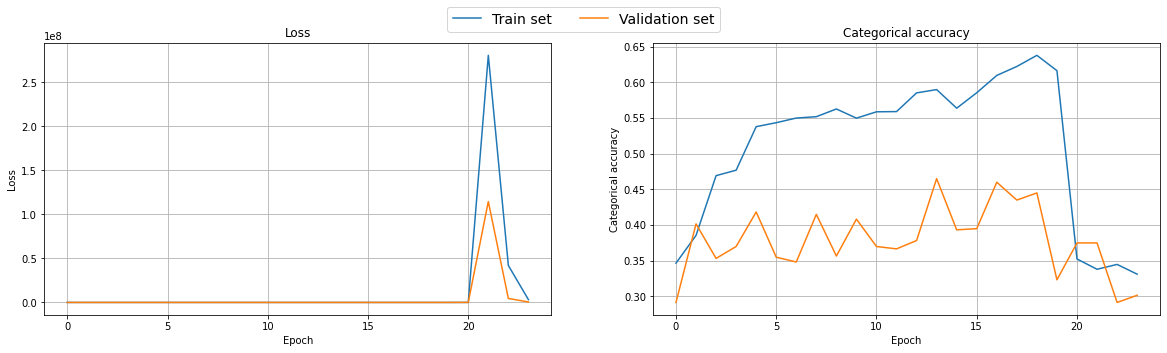

At the 24 th epoch: 

The loss: 3206091.75
The categorical_accuracy 0.3312698304653168
The val_loss: 525456.1875
The val_categorical_accuracy: 0.3016666769981384


In [ ]:
plot_history(network_history)

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
test_results = model.evaluate(x_test_norm, y_test, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

20/20 [==============================] - 1s 26ms/step - loss: 2.1503 - categorical_accuracy: 0.6661
Test results - Loss: 2.1502685546875 - Accuracy: 0.6661417484283447


0.6538461538461539
0.375
0.8333333333333334


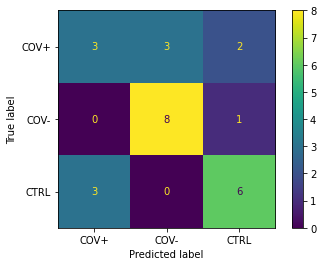

In [ ]:
df_res = patients_results(model, divided_spectra)

print(patients_accuracy(df_res))
print(patients_sensitivity(df_res))
print(patients_specifity(df_res))
patients_confusion_matrix(df_res)

## DenseNet

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test, x_test_norm, divided_spectra = get_preprocessed_data_1d(raw_data_pd,
                                                                                                        augment=True)
print(np.shape(x_train))
print(np.shape(y_train))

print(np.shape(x_val))
print(np.shape(y_val))

print(np.shape(x_test))
print(np.shape(y_test))

(6375, 991)
(6375, 3)
(590, 991)
(590, 3)
(636, 991)
(636, 3)


In [ ]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv1D(int(num_filter*compression), 3, use_bias=False ,padding='same',kernel_regularizer=l2(wt_decay) , kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter))))))(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv1D(int(int(input.shape[-1])*compression), 1, use_bias=False ,padding='same',kernel_regularizer=l2(wt_decay) , kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter*compression))))))(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling1D(pool_size=2)(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling1D(pool_size=2)(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(wt_decay))(flat)
    
    return output



l = 6
num_filter = 24
compression = 0.5
dropout_rate = 0.4
wt_decay = 0.01
num_classes = 3

input = Input(shape=(991, 1))
First_Conv2D = Conv1D(int(num_filter), 3, use_bias=False , padding='same', kernel_regularizer=l2(wt_decay), kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*num_filter)))))(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

#First_Transition = merge([First_Transition,First_Conv2D], mode='concat', concat_axis=-1)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

#Second_Transition = Concatenate(axis=-1)([Second_Transition,First_Transition,First_Conv2D])

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

#Third_Transition = Concatenate(axis=-1)([Third_Transition,Second_Transition,First_Transition,First_Conv2D])

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

model = Model(inputs=[input], outputs=[output])

model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy']
)
model.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 991, 1)]     0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 991, 24)      72          ['input_10[0][0]']               
                                                                                                  
 batch_normalization_141 (Batch  (None, 991, 24)     96          ['conv1d_24[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation_141 (Activation)    (None, 991, 24)      0           ['batch_normalization_141[0

In [ ]:
checkpoint_path = '/tmp/checkpoint' 
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

model_earlystopping_callback = EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0.01,
    patience=10,
    verbose=1
)



batch_size = 128
n_epochs = 50

network_history = model.fit(x_train, y_train, batch_size=batch_size, 
                            epochs=n_epochs, verbose=1,
                            callbacks=[model_earlystopping_callback,
                                       model_checkpoint_callback],
                            validation_data=(x_val, y_val))

Epoch 1/50
50/50 [==============================] - 24s 268ms/step - loss: 9.5909 - categorical_accuracy: 0.4168 - val_loss: 7.7895 - val_categorical_accuracy: 0.2966
Epoch 2/50
50/50 [==============================] - 9s 177ms/step - loss: 6.4351 - categorical_accuracy: 0.4809 - val_loss: 5.3527 - val_categorical_accuracy: 0.2966
Epoch 3/50
50/50 [==============================] - 9s 181ms/step - loss: 4.3946 - categorical_accuracy: 0.5355 - val_loss: 3.8114 - val_categorical_accuracy: 0.3576
Epoch 4/50
50/50 [==============================] - 9s 177ms/step - loss: 3.1420 - categorical_accuracy: 0.5485 - val_loss: 2.8567 - val_categorical_accuracy: 0.4034
Epoch 5/50
50/50 [==============================] - 9s 173ms/step - loss: 2.3523 - categorical_accuracy: 0.5711 - val_loss: 2.2600 - val_categorical_accuracy: 0.3898
Epoch 6/50
50/50 [==============================] - 9s 175ms/step - loss: 1.8710 - categorical_accuracy: 0.5776 - val_loss: 1.8750 - val_categorical_accuracy: 0.4288
Epo

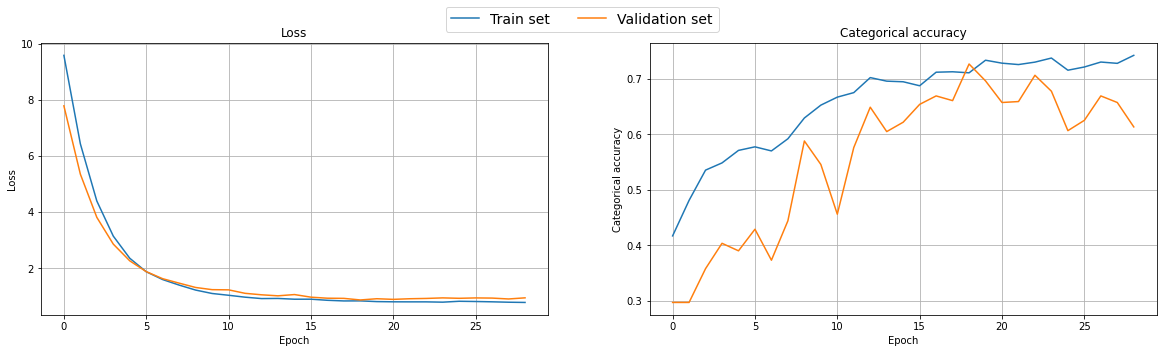

At the 29 th epoch: 

The loss: 0.775547206401825
The categorical_accuracy 0.7427451014518738
The val_loss: 0.93979811668396
The val_categorical_accuracy: 0.6135593056678772


In [ ]:
plot_history(network_history)

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
test_results = model.evaluate(x_test_norm, y_test, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

20/20 [==============================] - 2s 51ms/step - loss: 1.0363 - categorical_accuracy: 0.5849
Test results - Loss: 1.0362595319747925 - Accuracy: 0.5849056839942932


0.6153846153846154
0.375
0.8888888888888888


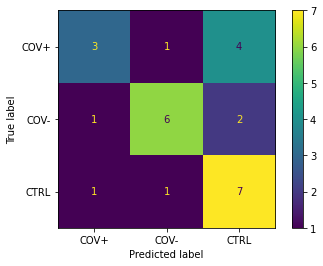

In [ ]:
df_res = patients_results(model, divided_spectra)

print(patients_accuracy(df_res))
print(patients_sensitivity(df_res))
print(patients_specifity(df_res))
patients_confusion_matrix(df_res)

#2D network(s)

## Metrics

In [ ]:
def patients_metrics2D(y_pred, y_true):

  true_pos, false_pos, true_neg, false_neg = 0.,0.,0.,0.

  y_pred = np.argmax(y_pred, axis=1)

  for idx, sing_y in enumerate(y_pred):

    if sing_y == 0:
      if y_true[idx]==0:
        true_pos+=1
      else:
        false_pos+=1
    else:
      if y_true[idx]==0:
        false_neg+=1
      else:
        true_neg+=1

  accuracy=(true_neg+true_pos)/len(y_true)

  try:
    specificity=true_neg/(true_neg+false_pos)
  except:
    specificity = float('NaN')
  try:
    sensitivity=true_pos/(true_pos+false_neg)
  except:
    sensitivity = float('NaN')


  return accuracy, specificity, sensitivity

## Preprocessing

In [ ]:
def get_preprocessed_data_2d(raw_dataset, test_size=0.15, division=True):
  clean_dataset = get_dataset_no_outliers(raw_data_pd, treshold=400)
  x, y = dataset_split2D(clean_dataset)
  x = normalize2D(x)
  
  if division:
    y= utils.to_categorical(y, 3)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y)
    return x_train, x_test, y_train, y_test
  
  else:
    #label_encoded = LabelEncoder()
    #y=label_encoded.fit_transform(y)
    return x, y

In [ ]:
def complete_spectra(x):
  while len(x) < 25:
    noise = np.random.normal(0,0.01,991)
    new_spectra = x[0]+noise
    x.append(new_spectra)
  return x

tr_labels = {
    'COV+': 0,
    'COV-': 1,
    'CTRL': 2
}

def dataset_split2D(data):
  x = []
  y = []
  temp_x = []

  last_user = data['user'][0]

  for idx, user in enumerate(data['user']):
    if user == last_user:
      temp_x.append(data['spectra'][idx])
    else:
      temp_x = complete_spectra(temp_x)
      x.append(np.array(temp_x))
      y.append(tr_labels[data['category'][idx-1]])
      temp_x = []
      last_user = user
      temp_x.append(data['spectra'][idx])

  temp_x = complete_spectra(temp_x)
  x.append(np.array(temp_x))
  y.append(tr_labels[data['category'][len(data)-1]]) 

  return np.array(x), np.array(y)

In [ ]:
def normalize2D(x):

  new_x=[]

  for patient in x:
    temp_x=[]
    for spectra in patient:
      #new_x.append(spectra/max(spectra))
      #new_x.append(spectra/spectra[0])

      #mean=np.mean(spectra)
      mean=spectra[0]
      if mean == 0:
        mean=1
      temp_x.append(np.array(spectra/mean))

    new_x.append(np.array(temp_x))

  return np.array(new_x)

In [ ]:
def reduce_y(y):
  new_y = []
  for single_y in y:
    if single_y[0] == 1:
      new_y.append(1)
    else:
      new_y.append(0)
    #new_y.append(temp_y)

  return np.array(new_y)

In [ ]:
x_train, x_test, y_train, y_test = get_preprocessed_data_2d(raw_data_pd)

In [ ]:
y_train_red = reduce_y (y_train)
y_test_red = reduce_y (y_test)

In [ ]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(85, 25, 991)
(85, 3)
(16, 25, 991)
(16, 3)


In [ ]:
print(np.shape(y_train_red))
print(np.shape(y_test_red))

(85,)
(16,)


## CONV2D (1 vs 1 vs 1)

In [ ]:
x_train, x_test, y_train, y_test = get_preprocessed_data_2d(raw_data_pd)

In [ ]:
def make_conv2D_model(input_dim = (25,991,1), optimizer = "adam",
                      activation= 'relu',
                      loss = 'categorical_crossentropy', metrics = 'categorical_accuracy',
                      dropout=True):

  input = Input(shape=input_dim)
  input = GaussianNoise(0.01)(input)

  #aver = AveragePooling2D(pool_size=(2,2), strides=(1,1), padding = "same")(input)

  


  t = Conv2D(20, kernel_size=(5,5), strides=(1,2), activation=activation, name = "conv_1")(input)
  t = Conv2D(20, kernel_size=(5,5), strides=(1,2), activation=activation, name = "conv_2")(t)
  t = AveragePooling2D(pool_size=(2,2), strides=(1,1), name = "maxpool_1")(t)
  #t = GaussianNoise(0.01)(t)

  t = Conv2D(20, kernel_size=(4,5), strides=(1,3), activation=activation, name = "conv_3")(t)
  t = Conv2D(20, kernel_size=(4,5), strides=(2,3), activation=activation, name = "conv_3a")(t)
  t = AveragePooling2D(pool_size=(2,4), strides=(1,2), name = "maxpool_2")(t)
  #t = GaussianNoise(0.01)(t)

  t = Conv2D(20, kernel_size=(4,5), strides=(2,3), activation=activation, name = "conv_4")(t)
  t = Conv2D(20, kernel_size=(1,3), strides=(1,2), activation=activation, name = "conv_4a")(t)


  flatten = Flatten()(t)
  if dropout:
    flatten = Dropout(0.5)(flatten)
  dense_1 = Dense(60, activation=activation, name = "dense_1", kernel_regularizer=regularizers.L2(l2=1e-2))(flatten)
  if dropout:
    flatten = Dropout(0.2)(dense_1)
  dense_2 = Dense(20, activation=activation, name = "dense_2", kernel_regularizer=regularizers.L2(l2=1e-2))(flatten)


  output = Dense(3, activation="softmax", name = "output")(dense_2)

  model = Model(input, output)

  model.compile(optimizer = optimizer, loss = loss, metrics = [metrics])  
    
  return model

In [ ]:
model2D = make_conv2D_model(dropout=True)
model2D.summary()

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_111 (InputLayer)      [(None, 25, 991, 1)]      0         
                                                                 
 conv_1 (Conv2D)             (None, 21, 494, 20)       520       
                                                                 
 conv_2 (Conv2D)             (None, 17, 245, 20)       10020     
                                                                 
 maxpool_1 (AveragePooling2D  (None, 16, 244, 20)      0         
 )                                                               
                                                                 
 conv_3 (Conv2D)             (None, 13, 80, 20)        8020      
                                                                 
 conv_3a (Conv2D)            (None, 5, 26, 20)         8020      
                                                          

In [ ]:
batch_size = 16
n_epochs = 250

checkpoint_path = '/tmp/checkpoint' 
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

network_history = model2D.fit(x_train, y_train, batch_size=batch_size, 
                              epochs=n_epochs, verbose=1,
                              callbacks=[model_checkpoint_callback],
                              validation_split=0.2)

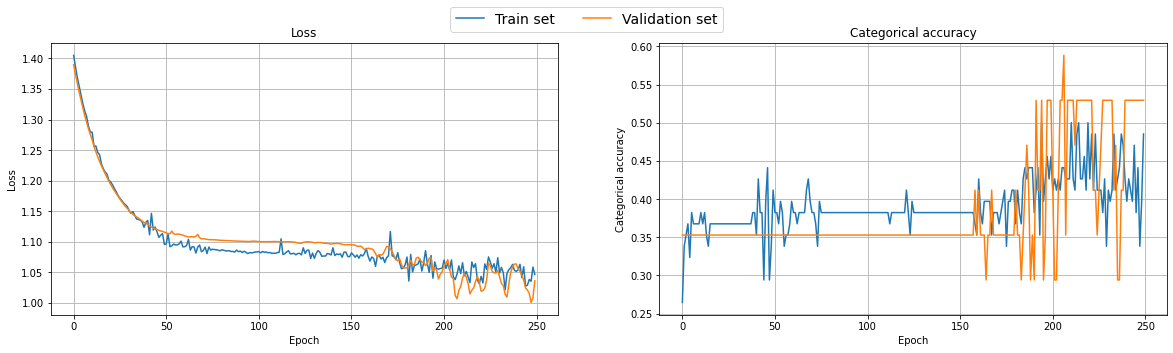

At the 250 th epoch: 

The loss: 1.0467329025268555
The categorical_accuracy 0.4852941036224365
The val_loss: 1.0364259481430054
The val_categorical_accuracy: 0.529411792755127


In [ ]:
plot_history(network_history, validation=True)

In [ ]:
model2D.load_weights(checkpoint_path)

In [ ]:
test_results = model2D.evaluate(x_test, y_test, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

1/1 [==============================] - 0s 21ms/step - loss: 0.9854 - categorical_accuracy: 0.5625
Test results - Loss: 0.9854183197021484 - Accuracy: 0.5625


1/1 [==============================] - 0s 84ms/step
              precision    recall  f1-score   support

        COV+       0.75      0.60      0.67         5
        COV-       0.67      0.33      0.44         6
        CTRL       0.44      0.80      0.57         5

    accuracy                           0.56        16
   macro avg       0.62      0.58      0.56        16
weighted avg       0.62      0.56      0.55        16



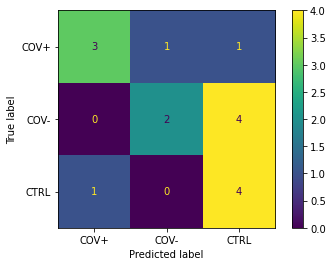

In [ ]:
labels = ['COV+', 'COV-', 'CTRL']
y_pred = np.argmax(model2D.predict(x_test), axis=1)
y_test_arged = np.argmax(y_test, axis=1)
print(classification_report(y_test_arged, y_pred, target_names=labels))

mat=ConfusionMatrixDisplay(confusion_matrix(y_test_arged, y_pred),
                           display_labels=labels)
mat.plot()
plt.show()

### LO(P)OCV

In [ ]:
!pip install scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
x, y = get_preprocessed_data_2d(raw_data_pd, division=False)

In [ ]:
kfold = StratifiedKFold(n_splits=30, shuffle=True)

In [ ]:
cv_acc_tern=[]
cv_acc=[]
cv_sens=[]
cv_spec=[]

y_ohe= utils.to_categorical(y, 3)
for train_index, val_index in kfold.split(x, y):
  model = KerasClassifier(model=make_conv2D_model, epochs=250, batch_size=16, verbose=0)
  
  checkpoint_path = '/tmp/checkpoint' 
  model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    mode='max',
    save_best_only=True)
  
  model.fit(x[train_index], y_ohe[train_index], callbacks= [model_checkpoint_callback], validation_data=(x[val_index], y_ohe[val_index]))

  pred = model.predict(x[val_index]) # predicts single-digit classes

  fold_acc_tern = accuracy_score(y_ohe[val_index], pred)
  fold_acc, fold_spec, fold_sens = patients_metrics2D(pred, y[val_index])

  # weighted mean
  for i in y_ohe[val_index]:
    cv_acc_tern.append(fold_acc_tern)
    cv_acc.append(fold_acc)
    cv_spec.append(fold_spec)
    cv_sens.append(fold_sens)

  print(f'acc = {fold_acc}\tNum_test = {len(y_ohe[val_index])}')
  print(f'spec = {fold_spec}')
  print(f'sens = {fold_sens}')

acc = 1.0	Num_test = 4
spec = 1.0
sens = 1.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.75	Num_test = 4
spec = 1.0
sens = 0.0
acc = 0.6666666666666666	Num_test = 3
spec = 1.0
sens = 0.0
acc = 0.6666666666666666	Num_test = 3
spec = 1.0
sens = 0.0
acc = 0.6666666666666666	Num_test = 3
spec = 1.0
sens = 0.0
acc = 0.6666666666666666	Num_test = 3
spec = 0.5
sens = 1.0
acc = 0.0	Num_test = 3
spec = 0.0
sens = 0.0
acc = 0.6666666666666666	Num_test = 3
spec = 1.0
sens = 0.0
acc = 0.6666666666666666	Num_test = 3
spec = 1.0
sens = 0.0
acc = 0.6666666666666666	Num_test = 3
spec = 1.0
sens = 0.0
acc = 0.3333333333333333	Num_t

In [ ]:
print(np.mean(cv_acc_tern))
print(np.mean(cv_acc))
print(np.mean(cv_spec))
print(np.mean(cv_sens))

0.3762376237623763
0.6930693069306932
0.9108910891089109
0.15841584158415842


### Hyperband

In [ ]:
def make_conv2D_model(hp):

  num_filters1 = hp.Int('num_filters1', min_value=2, max_value=14, step=2)
  num_filters2 = hp.Int('num_filters2', min_value=2, max_value=14, step=2)

  num_dense1 = hp.Int('dense1', min_value=52, max_value=126, step=1)
  num_dense2 = hp.Int('dense2', min_value=10, max_value=50, step=1)

  drop_prob = hp.Float('drop', min_value=0.0, max_value=0.99, step=0.1)
  gaussnoise = hp.Float('gaus', min_value=0.0, max_value=0.5, step = 0.01)
  learning_rate = hp.Float('lr', min_value=0.01, max_value=0.1, step = 0.01)


  input_dim = (25,991,1)
  optimizer = Adam(learning_rate=learning_rate)
  activation= 'relu'
  loss = 'categorical_crossentropy'
  metrics = 'categorical_accuracy'
  dropout=True



  input = Input(shape=input_dim)
  input = GaussianNoise(gaussnoise)(input)

  aver = AveragePooling2D(pool_size=(2,2), strides=(1,1), padding = "same")(input)

  


  t = Conv2D(num_filters1, kernel_size=(5,5), strides=(1,1), activation=activation, name = "conv_1")(aver)
  t = Conv2D(num_filters1, kernel_size=(5,5), strides=(1,1), activation=activation, name = "conv_2")(t)
  t = AveragePooling2D(pool_size=(2,4), strides=(2,4), name = "maxpool_1")(t)

  t = Conv2D(num_filters1+num_filters2, kernel_size=(2,2), strides=(1,1), activation=activation, name = "conv_3")(t)
  t = Conv2D(num_filters1+num_filters2, kernel_size=(2,2), strides=(2,2), activation=activation, name = "conv_3a")(t)
  t = AveragePooling2D(pool_size=(2,4), strides=(2,4), name = "maxpool_2")(t)

  t = Conv2D(num_filters2, kernel_size=(1,2), strides=(1,3), activation=activation, name = "conv_4")(t)
  t = Conv2D(num_filters2, kernel_size=(1,2), strides=(1,1), activation=activation, name = "conv_4a")(t)


  flatten = Flatten()(t)
  if dropout:
    flatten = Dropout(drop_prob)(flatten)
  dense_1 = Dense(num_dense1, activation=activation, name = "dense_1")(flatten)
  if dropout:
    flatten = Dropout(drop_prob)(dense_1)
  dense_2 = Dense(num_dense2, activation=activation, name = "dense_2")(flatten)


  output = Dense(3, activation="sigmoid", name = "output")(dense_1)

  model = Model(input, output)

  model.compile(optimizer = optimizer, loss = loss, metrics = [metrics])  
    
  return model

In [ ]:
tuner = kt.Hyperband(make_conv2D_model,
                     objective='val_categorical_accuracy',
                     max_epochs=200,
                     factor=3,
                     directory='my_dir',
                     project_name='conv2d5')

x_train, x_test, y_train, y_test = get_preprocessed_data_2d(raw_data_pd)

tuner.search(x_train, y_train, epochs=50, validation_split=0.3)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

In [ ]:
print(best_hps.get('num_filters1'))
print(best_hps.get('num_filters2'))

print(best_hps.get('dense1'))
print(best_hps.get('dense2'))

print(best_hps.get('drop'))
print(best_hps.get('lr'))
print(best_hps.get('gaus'))

6
8
68
24
0.2
0.01
0.32


## CONV2D (1 vs 1)

In [ ]:
x_train, x_test, y_train, y_test = get_preprocessed_data_2d(raw_data_pd)
y_train_red = reduce_y (y_train)
y_test_red = reduce_y (y_test)

In [ ]:
def make_conv2D_model(input_dim = (25,991,1), optimizer = Adam(learning_rate=0.1),
                      activation= 'relu',
                      loss = 'binary_crossentropy', metrics = 'accuracy',
                      dropout=False):

  input = Input(shape=input_dim)
  input = GaussianNoise(0.02)(input)

  aver = AveragePooling2D(pool_size=(2,1), strides=(1,1), padding = "same")(input)

  


  t = Conv2D(4, kernel_size=(5,5), strides=(1,1), activation=activation, name = "conv_1")(aver)
  t = Conv2D(4, kernel_size=(5,5), strides=(1,1), activation=activation, name = "conv_2")(t)
  t = AveragePooling2D(pool_size=(2,4), strides=(2,4), name = "maxpool_1")(t)
  #t = GaussianNoise(0.09)(t)

  t = Conv2D(10, kernel_size=(2,2), strides=(1,1), activation=activation, name = "conv_3")(t)
  t = Conv2D(10, kernel_size=(2,2), strides=(2,2), activation=activation, name = "conv_3a")(t)
  t = AveragePooling2D(pool_size=(2,4), strides=(2,4), name = "maxpool_2")(t)
  #t = GaussianNoise(0.09)(t)

  t = Conv2D(4, kernel_size=(1,2), strides=(1,3), activation=activation, name = "conv_4")(t)
  t = Conv2D(4, kernel_size=(1,2), strides=(1,1), activation=activation, name = "conv_4a")(t)


  flatten = Flatten()(t)
  if dropout:
    flatten = Dropout(0.3)(flatten)
  dense_1 = Dense(103, activation=activation, name = "dense_1")(flatten)
  if dropout:
    flatten = Dropout(0.3)(dense_1)
  dense_2 = Dense(23, activation=activation, name = "dense_2")(flatten)


  output = Dense(1, activation="sigmoid", name = "output")(dense_1)

  model = Model(input, output)

  model.compile(optimizer = optimizer, loss = loss, metrics = [metrics])  
    
  return model

In [ ]:
model2D = make_conv2D_model(dropout=False)
model2D.summary()

NameError: ignored

In [ ]:
batch_size = 10
n_epochs = 100

network_history = model2D.fit(x_train, y_train_red, batch_size=batch_size, 
                              epochs=n_epochs, verbose=1,
                              validation_split=0.)

Epoch 1/100
9/9 [==============================] - 0s 8ms/step - loss: 0.6074 - accuracy: 0.7059
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6074 - accuracy: 0.7059
Epoch 3/100
9/9 [==============================] - 0s 9ms/step - loss: 0.6065 - accuracy: 0.7059
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6072 - accuracy: 0.7059
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6081 - accuracy: 0.7059
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6073 - accuracy: 0.7059
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 0.6071 - accuracy: 0.7059
Epoch 8/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6077 - accuracy: 0.7059
Epoch 9/100
9/9 [==============================] - 0s 6ms/step - loss: 0.6065 - accuracy: 0.7059
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 0.6076 - accuracy: 0.7059
Epoch 11/100
9/9 [===========

KeyError: ignored

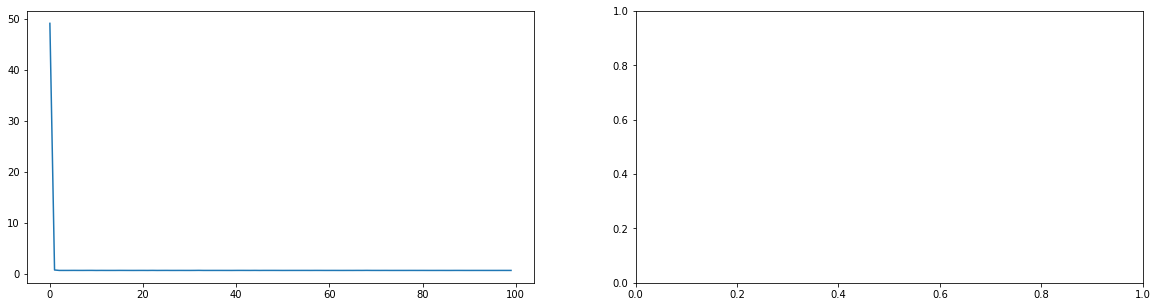

In [ ]:
plot_history_bin(network_history, validation=True)

In [ ]:
test_results = model2D.evaluate(x_test, y_test_red, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

1/1 [==============================] - 0s 133ms/step - loss: 0.6214 - accuracy: 0.6875
Test results - Loss: 0.6214046478271484 - Accuracy: 0.6875


1/1 [==============================] - 0s 67ms/step
               precision    recall  f1-score   support

COV- and CTRL       0.69      1.00      0.81        11
         COV+       0.00      0.00      0.00         5

     accuracy                           0.69        16
    macro avg       0.34      0.50      0.41        16
 weighted avg       0.47      0.69      0.56        16



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


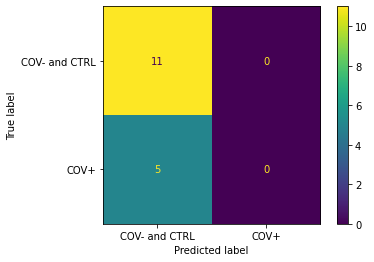

In [ ]:
labels = ['COV- and CTRL', 'COV+']#, 'CTRL']
y_pred = [int(i) for i in model2D.predict(x_test)]
print(classification_report(y_test_red, y_pred, target_names=labels))

mat=ConfusionMatrixDisplay(confusion_matrix(y_test_red, y_pred),
                           display_labels=labels)
mat.plot()
plt.show()

### Hyperband

In [ ]:
def make_conv2D_model_hp(hp):

  input_dim = (25,991,1)
  activation= 'relu'
  loss = 'binary_crossentropy'
  metrics = 'accuracy'
  dropout=True

  num_filters1 = hp.Int('num_filters1', min_value=2, max_value=14, step=2)
  num_filters2 = hp.Int('num_filters2', min_value=2, max_value=14, step=2)
  num_filters3 = hp.Int('num_filters3', min_value=2, max_value=14, step=2)

  num_dense = hp.Int('dense', min_value=12, max_value=126, step=1)
  drop_prob = hp.Float('drop', min_value=0.0, max_value=0.99, step=0.1)
  gaussnoise = hp.Float('gaus', min_value=0.0, max_value=0.5, step = 0.01)
  learning_rate = hp.Float('lr', min_value=0.01, max_value=0.1, step = 0.01)

  input = Input(shape=input_dim)

  aver = AveragePooling2D(pool_size=(2,1), strides=(1,1), padding = "same")(input)

  gaussian = GaussianNoise(gaussnoise)(aver)


  conv_1 = Conv2D(num_filters1, kernel_size=(5,5), strides=(1,1), activation=activation, name = "conv_1")(gaussian)
  conv_2 = Conv2D(num_filters1, kernel_size=(5,5), strides=(1,1), activation=activation, name = "conv_2")(conv_1)
  maxpool_1 = MaxPool2D(pool_size=(2,4), strides=(2,4), name = "maxpool_1")(conv_2)
  maxpool_1 = GaussianNoise(gaussnoise)(maxpool_1)

  conv_3 = Conv2D(num_filters2, kernel_size=(2,2), strides=(1,1), activation=activation, name = "conv_3")(maxpool_1)
  conv_3 = Conv2D(num_filters2, kernel_size=(2,2), strides=(2,2), activation=activation, name = "conv_3a")(conv_3)
  maxpool_2 = MaxPool2D(pool_size=(2,4), strides=(2,4), name = "maxpool_2")(conv_3)
  maxpool_2 = GaussianNoise(gaussnoise)(maxpool_2)

  conv_4 = Conv2D(num_filters3, kernel_size=(1,2), strides=(1,3), activation=activation, name = "conv_4")(maxpool_2)
  conv_4 = Conv2D(num_filters3, kernel_size=(1,2), strides=(1,1), activation=activation, name = "conv_4a")(conv_4)


  flatten = Flatten()(conv_4)
  if dropout:
    flatten = Dropout(drop_prob)(flatten)
  dense_1 = Dense(num_dense, activation=activation, name = "dense_1")(flatten)


  output = Dense(1, activation="sigmoid", name = "output")(dense_1)

  model = Model(input, output)

  optimizer = Adam(lr=learning_rate)
  model.compile(optimizer = optimizer, loss = loss, metrics = [metrics])  
    
  return model

In [ ]:
tuner = kt.Hyperband(make_conv2D_model_hp,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='conv2d5')

x_train, x_test, y_train, y_test = get_preprocessed_data_2d(raw_data_pd)
y_train_red = reduce_y (y_train)
y_test_red = reduce_y (y_test)

tuner.search(x_train, y_train_red, epochs=50, validation_split=0.2)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

Trial 254 Complete [00h 00m 08s]
val_accuracy: 0.6470588445663452

Best val_accuracy So Far: 0.6470588445663452
Total elapsed time: 00h 08m 40s


In [ ]:
print(best_hps.get('num_filters1'))
print(best_hps.get('num_filters2'))
print(best_hps.get('num_filters3'))
print(best_hps.get('dense'))
print(best_hps.get('drop'))
print(best_hps.get('lr'))
print(best_hps.get('gaus'))

4
10
4
103
0.9
0.04
0.09


## CONV2D part2

In [ ]:
x_train, x_test, y_train, y_test = get_preprocessed_data_2d(raw_data_pd)

In [ ]:
def make_conv2D_model(input_dim = (25,991,1), optimizer = 'adam', activation= 'relu',
                      loss = 'categorical_crossentropy', metrics = 'categorical_accuracy',
                      dropout=False):

  input = Input(shape=input_dim)

  aver = AveragePooling2D(pool_size=(1,2), strides=(1,1),name = "average_1")(input)# media tra spettri

  gaussian = GaussianNoise(0.01)(aver)

  conv_1 = Conv2D(50, kernel_size=(5,5), strides=(3,3), activation=activation, name = "conv_1")(gaussian)
  aver = AveragePooling2D(pool_size=(2,2), strides=(1,1),  name = "average_2")(conv_1)# media tra spettri
  conv_2 = Conv2D(50, kernel_size=(5,5), strides=(2,4), activation=activation, name = "conv_2")(aver)
  aver = AveragePooling2D(pool_size=(3,3), strides=(1,1), name = "average_3", padding='same')(conv_2)# media tra spettri
  aver = Conv2D(10, kernel_size=(2,2), strides=(2,4), activation=activation, name = "conv_3", padding='same')(aver)
  
  flatten = Flatten()(aver)
  if dropout:
    flatten = Dropout(0.5)(flatten)
  dense = Dense(20, activation=activation, name = "dense")(flatten)

  output = Dense(3, activation="softmax", name = "output")(dense)

  model = Model(input, output)

  model.compile(optimizer = optimizer, loss = loss, metrics = [metrics])  
    
  return model

In [ ]:
model2D = make_conv2D_model(dropout=True)
model2D.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 25, 991, 1)]      0         
                                                                 
 average_1 (AveragePooling2D  (None, 25, 990, 1)       0         
 )                                                               
                                                                 
 gaussian_noise_25 (Gaussian  (None, 25, 990, 1)       0         
 Noise)                                                          
                                                                 
 conv_1 (Conv2D)             (None, 7, 329, 50)        1300      
                                                                 
 average_2 (AveragePooling2D  (None, 6, 328, 50)       0         
 )                                                               
                                                          

In [ ]:
batch_size = 8
n_epochs = 300

network_history = model2D.fit(x_train, y_train, batch_size=batch_size, 
                              epochs=n_epochs, verbose=1,
                              validation_split=0.3)

Epoch 1/300
8/8 [==============================] - 1s 30ms/step - loss: 1.1205 - categorical_accuracy: 0.3051 - val_loss: 1.1240 - val_categorical_accuracy: 0.3462
Epoch 2/300
8/8 [==============================] - 0s 8ms/step - loss: 1.1017 - categorical_accuracy: 0.3559 - val_loss: 1.1139 - val_categorical_accuracy: 0.2308
Epoch 3/300
8/8 [==============================] - 0s 8ms/step - loss: 1.0970 - categorical_accuracy: 0.3729 - val_loss: 1.1012 - val_categorical_accuracy: 0.2308
Epoch 4/300
8/8 [==============================] - 0s 8ms/step - loss: 1.0981 - categorical_accuracy: 0.3729 - val_loss: 1.0979 - val_categorical_accuracy: 0.4231
Epoch 5/300
8/8 [==============================] - 0s 10ms/step - loss: 1.1135 - categorical_accuracy: 0.2542 - val_loss: 1.0947 - val_categorical_accuracy: 0.4231
Epoch 6/300
8/8 [==============================] - 0s 10ms/step - loss: 1.0993 - categorical_accuracy: 0.2712 - val_loss: 1.0958 - val_categorical_accuracy: 0.4231
Epoch 7/300
8/8 [==

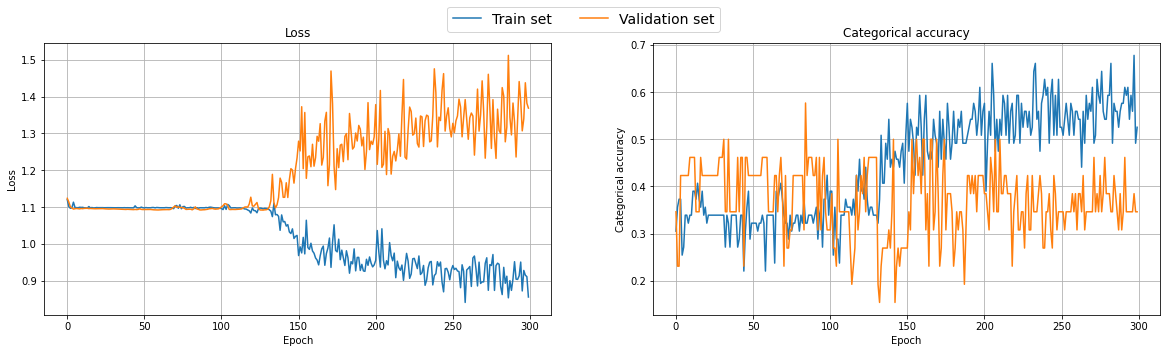

At the 300 th epoch: 

The loss: 0.8563143014907837
The categorical_accuracy 0.5254237055778503
The val_loss: 1.368586778640747
The val_categorical_accuracy: 0.3461538553237915


In [ ]:
plot_history(network_history, validation=True)

In [ ]:
test_results = model2D.evaluate(x_test, y_test, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}")

1/1 [==============================] - 0s 19ms/step - loss: 1.2862 - categorical_accuracy: 0.4375
Test results - Loss: 1.2862355709075928 - Accuracy: 0.4375


1/1 [==============================] - 0s 66ms/step
              precision    recall  f1-score   support

        COV+       0.38      0.60      0.46         5
        COV-       0.60      0.50      0.55         6
        CTRL       0.33      0.20      0.25         5

    accuracy                           0.44        16
   macro avg       0.44      0.43      0.42        16
weighted avg       0.45      0.44      0.43        16



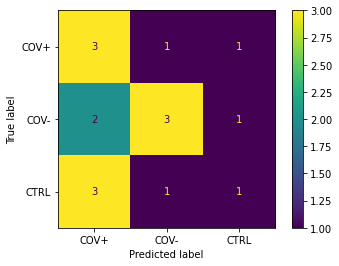

In [ ]:
labels = ['COV+', 'COV-', 'CTRL']
y_pred = np.argmax(model2D.predict(x_test), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred,
      target_names=labels))

mat=ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=1), y_pred),
                           display_labels=labels)
mat.plot()
plt.show()